look into how hadronic jets can help

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

########## backgrounds ##########
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbackgrounds_v2.json')))
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_191101.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_v2.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
# datasets.update(datadatasets) # skip data for now

mapping = {}
mapping.update(bkgmapping)
# mapping.update(datamapping)
####################################

In [18]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor': 'w',#(0,0,0,.5),
    'linewidth': 0,
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'w',
    'elinewidth': 1,
    'emarker': '_'
}

In [4]:

"""AK4PFCHS multiplicy, HT, pT"""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#AK4CHS jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 10, 0, 300)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 10, 0, 500)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
        })
        ## corrections NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
        )

        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets[isControl]
        ak4jets = ak4jets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        channel_ = channel_[isControl]

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>20)&(np.abs(ak4jets.eta)<2.5)]
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.jetid.sum(), weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.flatten(), weight=jwgt, channel=jchannel)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

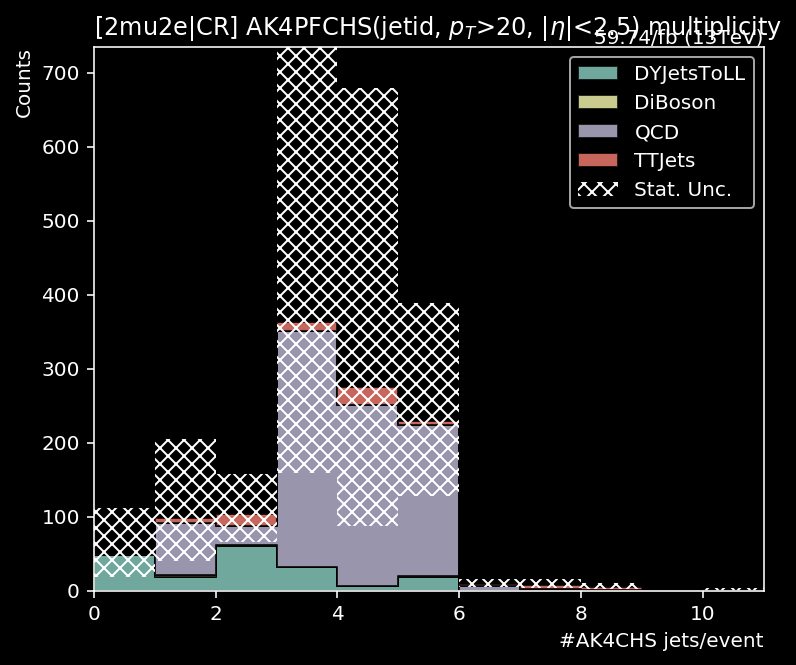

In [19]:
fig, ax=plt.subplots(1,1, figsize=(6,5))
hist.plot1d(output['njets_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS(jetid, $p_T$>20, |$\eta$|<2.5) multiplicity', x=0.0, ha="left");

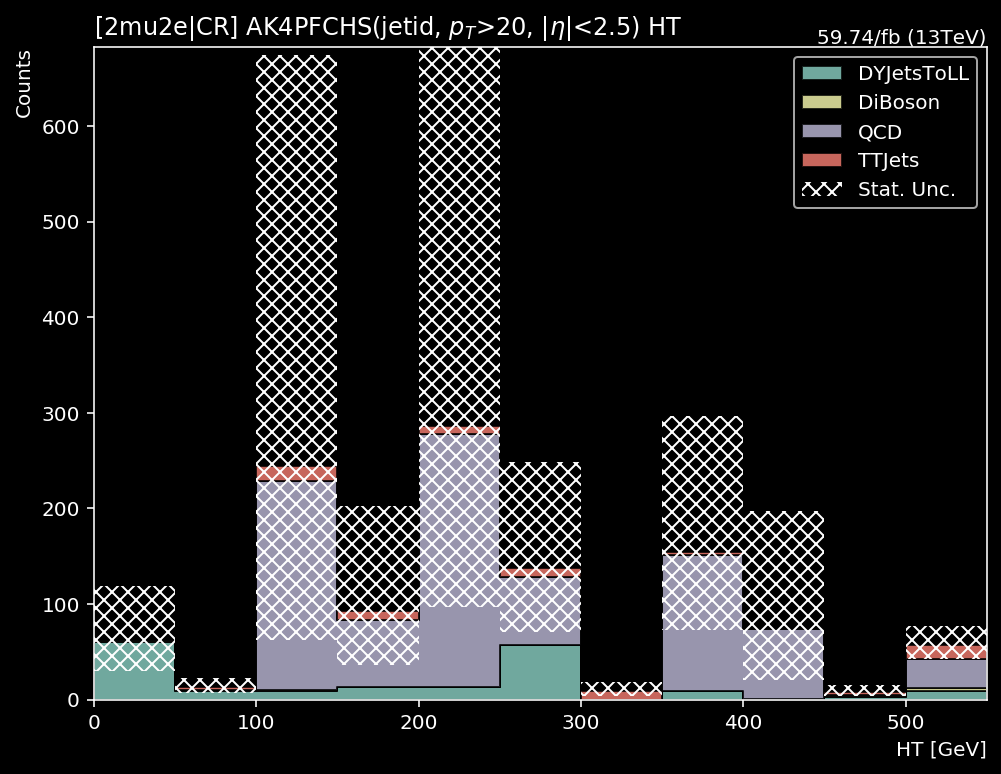

In [20]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS(jetid, $p_T$>20, |$\eta$|<2.5) HT', x=0.0, ha="left");

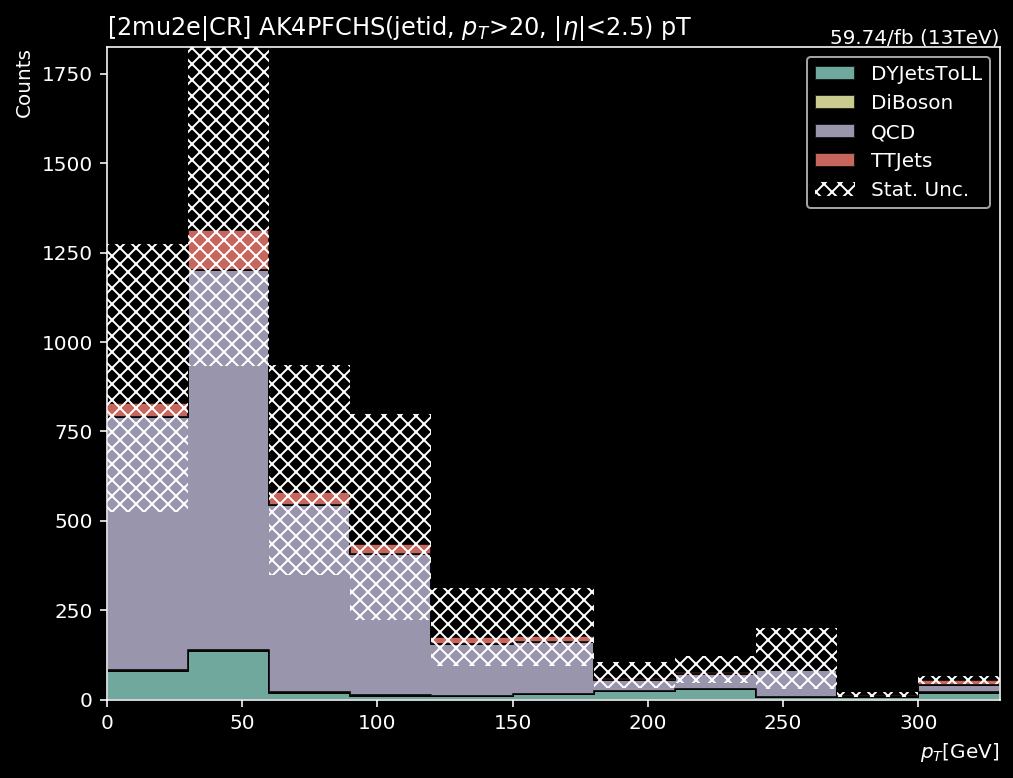

In [23]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS(jetid, $p_T$>20, |$\eta$|<2.5) pT', x=0.0, ha="left");

## All region

In [4]:

"""AK4PFCHS multiplicy, HT, pT; EGM-type LJ pfiso; and more."""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "# jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 10, 0, 300)
        eta_axis = hist.Bin('eta', '$\eta$', 25, -2.5, 2.5)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 20, 0, 500)
        iso_axis = hist.Bin('iso', 'iso value', 20, 0, 1)
        siso_axis = hist.Bin('iso', 'iso value', 20, 0, 0.5)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        type_axis = hist.Cat('ljtype', 'ljtype')
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'eta': hist.Hist('Counts', dataset_axis, eta_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
            'nlj': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'ljpfiso_all05': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis, type_axis),
            'ljpfiso_nopu05': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis, type_axis),
            'ljpfiso_dbeta': hist.Hist('Counts', dataset_axis, siso_axis, channel_axis, type_axis),
            'ljcands': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis, type_axis),
            'nmuons': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'mupt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
        })
        
        ## NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            hadfrac=df['akjet_ak4PFJetsCHS_hadronEnergyFraction'],
            emfrac=df['akjet_ak4PFJetsCHS_emEnergyFraction'],
        )
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
            selector=df['muon_selectors']
        )
        muons.add_attributes(isoloose=np.bitwise_and(muons.selector, 1<<7)==(1<<7),
                             isomedium=np.bitwise_and(muons.selector, 1<<8)==(1<<8),
                             isotight=np.bitwise_and(muons.selector, 1<<9)==(1<<9),
                            )

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfisoAll05=df['pfjet_pfIsolation05'],
            pfisoNopu05=df['pfjet_pfIsolationNoPU05'],
            pfisoDbeta=df['pfjet_pfiso'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        muons = muons[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        muons = muons
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>30)&(np.abs(ak4jets.eta)<2.5)]
        muons=muons[(muons.pt>5.)&(muons.isoloose)]
        
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.counts, weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        output['nmuons'].fill(dataset=dataset, multiplicity=muons.counts, weight=wgt, channel=channel_)
        
        mwgt = (muons.pt.ones_like()*wgt).flatten()
        mchannel = (muons.pt.ones_like()*channel_).flatten()
        output['mupt'].fill(dataset=dataset, pt=muons.pt.flatten(), weight=mwgt, channel=mchannel)
        
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.max(), weight=wgt, channel=channel_)
        output['eta'].fill(dataset=dataset, eta=ak4jets.eta.flatten(), weight=jwgt, channel=jchannel)
        
        ljwgt = (dileptonjets.pt.ones_like()*wgt).flatten()
        ljchannel=(dileptonjets.pt.ones_like()*channel_).flatten()
        output['nlj'].fill(dataset=dataset, multiplicity=dileptonjets.counts, weight=wgt, channel=channel_)
        
        
        egammalj = dileptonjets[dileptonjets.iseltype] # iseltype
        egwgt = (egammalj.pt.ones_like()*wgt).flatten()
        egchannel = (egammalj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=egammalj.ncands.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_all05'].fill(dataset=dataset, iso=egammalj.pfisoAll05.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_nopu05'].fill(dataset=dataset, iso=egammalj.pfisoNopu05.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_dbeta'].fill(dataset=dataset, iso=egammalj.pfisoDbeta.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        
        mulj = dileptonjets[dileptonjets.ismutype]
        muljwgt = (mulj.pt.ones_like()*wgt).flatten()
        muljchannel = (mulj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=mulj.ncands.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_all05'].fill(dataset=dataset, iso=mulj.pfisoAll05.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_nopu05'].fill(dataset=dataset, iso=mulj.pfisoNopu05.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_dbeta'].fill(dataset=dataset, iso=mulj.pfisoDbeta.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets", sorting='integral'),
                                                         mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

In [44]:
h = output['njets_cat'][notdata].integrate('channel', slice(1,2))#.sum('cat')
ax = 'multiplicity'

def left_right_bkg(hist, axis, cut):
    for d in hist.identifiers('cat'):
        print(f'[{str(d):>10}]', end='\t')
        h = hist.integrate('cat', d)
        edges_ = h.axis(axis).edges()
        low, high = edges_[0], edges_[-1]
        leftVal = h.integrate(axis, slice(low, cut)).values()[()]
        rightVal = h.integrate(axis, slice(cut, high)).values()[()]
        totalVal = h.integrate(axis, slice(low, high)).values()[()]
        print(f'<{cut}:\t{leftVal:.2f}/{totalVal:.2f}\t{leftVal/totalVal*100:.2f}%', end='\t|  ')
        print(f'>{cut}:\t{rightVal:.2f}/{totalVal:.2f}\t{rightVal/totalVal*100:.2f}%')
    print('_'*80)
    hist = hist.sum('cat')
    edges_ = hist.axis(axis).edges()
    low, high = edges_[0], edges_[-1]
    leftVal = hist.integrate(axis, slice(low, cut)).values()[()]
    rightVal = hist.integrate(axis, slice(cut, high)).values()[()]
    totalVal = hist.integrate(axis, slice(low, high)).values()[()]
    print('[     Total]', end='\t')
    print(f'<{cut}:\t{leftVal:.2f}/{totalVal:.2f}\t{leftVal/totalVal*100:.2f}%', end='\t|  ')
    print(f'>{cut}:\t{rightVal:.2f}/{totalVal:.2f}\t{rightVal/totalVal*100:.2f}%')
    print('+'*80)

left_right_bkg(h, ax, 3)
left_right_bkg(h, ax, 4)

[DYJetsToLL]	<3:	510.61/561.25	90.98%	|  >3:	50.64/561.25	9.02%
[   DiBoson]	<3:	13.59/18.16	74.85%	|  >3:	4.57/18.16	25.15%
[       QCD]	<3:	1203.76/3211.19	37.49%	|  >3:	2007.43/3211.19	62.51%
[    TTJets]	<3:	73.06/213.04	34.30%	|  >3:	139.98/213.04	65.70%
________________________________________________________________________________
[     Total]	<3:	1801.02/4003.64	44.98%	|  >3:	2202.62/4003.64	55.02%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[DYJetsToLL]	<4:	548.62/561.25	97.75%	|  >4:	12.63/561.25	2.25%
[   DiBoson]	<4:	16.24/18.16	89.47%	|  >4:	1.91/18.16	10.53%
[       QCD]	<4:	2973.89/3211.19	92.61%	|  >4:	237.31/3211.19	7.39%
[    TTJets]	<4:	130.93/213.04	61.46%	|  >4:	82.11/213.04	38.54%
________________________________________________________________________________
[     Total]	<4:	3669.68/4003.64	91.66%	|  >4:	333.96/4003.64	8.34%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


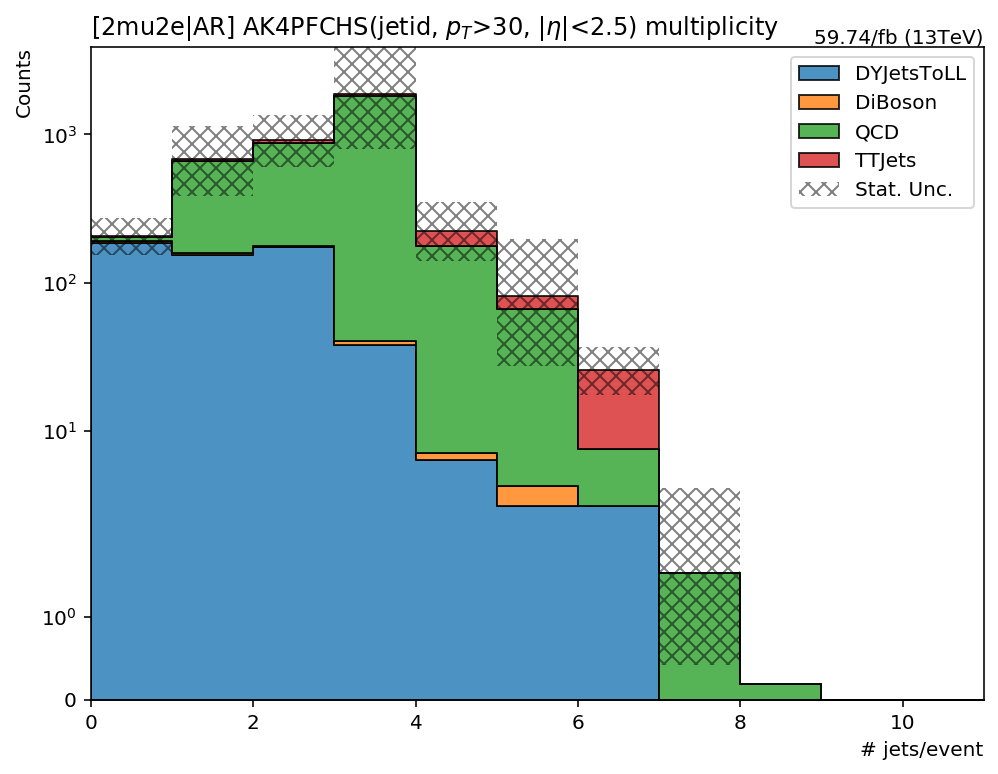

In [45]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['njets_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) multiplicity', x=0.0, ha="left");

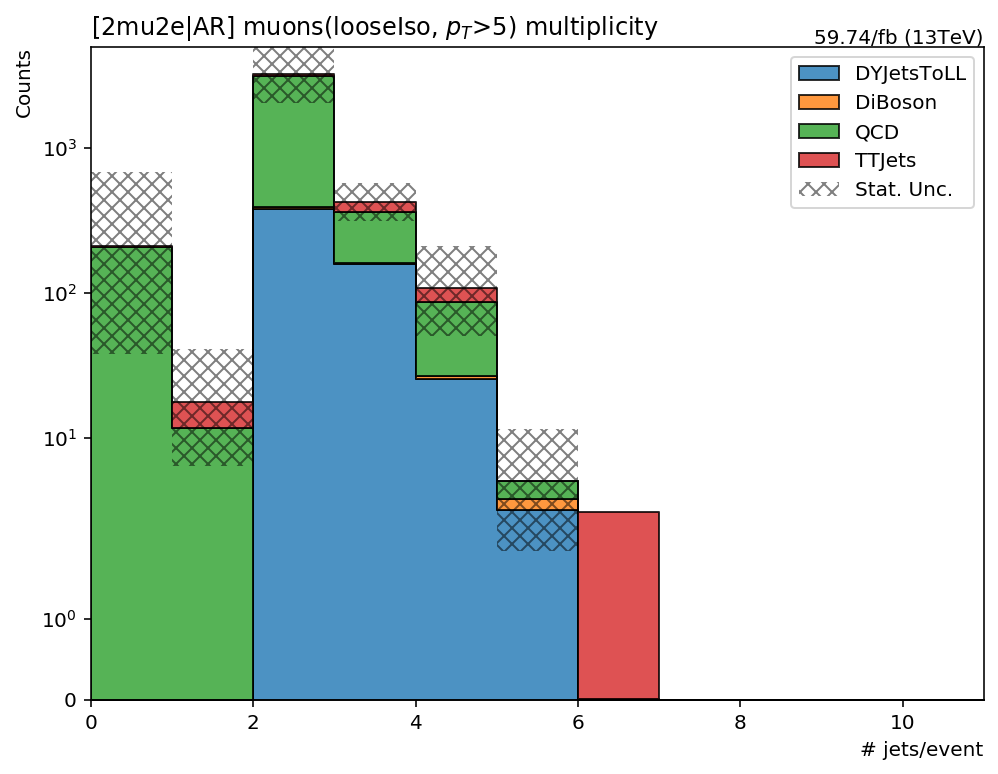

In [35]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['nmuons_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons(looseIso, $p_T$>5) multiplicity', x=0.0, ha="left");

In [46]:
h = output['ht_cat'][notdata].integrate('channel', slice(1,2))
ax = 'ht'

left_right_bkg(h, ax, 200)
left_right_bkg(h, ax, 300)

[DYJetsToLL]	<200:	442.33/542.30	81.57%	|  >200:	99.97/542.30	18.43%
[   DiBoson]	<200:	11.48/15.53	73.91%	|  >200:	4.05/15.53	26.09%
[       QCD]	<200:	2343.02/3159.99	74.15%	|  >200:	816.97/3159.99	25.85%
[    TTJets]	<200:	94.41/191.78	49.23%	|  >200:	97.37/191.78	50.77%
________________________________________________________________________________
[     Total]	<200:	2891.24/3909.61	73.95%	|  >200:	1018.36/3909.61	26.05%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[DYJetsToLL]	<300:	529.64/542.30	97.67%	|  >300:	12.66/542.30	2.33%
[   DiBoson]	<300:	12.78/15.53	82.28%	|  >300:	2.75/15.53	17.72%
[       QCD]	<300:	2928.70/3159.99	92.68%	|  >300:	231.29/3159.99	7.32%
[    TTJets]	<300:	143.11/191.78	74.62%	|  >300:	48.67/191.78	25.38%
________________________________________________________________________________
[     Total]	<300:	3614.23/3909.61	92.44%	|  >300:	295.37/3909.61	7.56%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

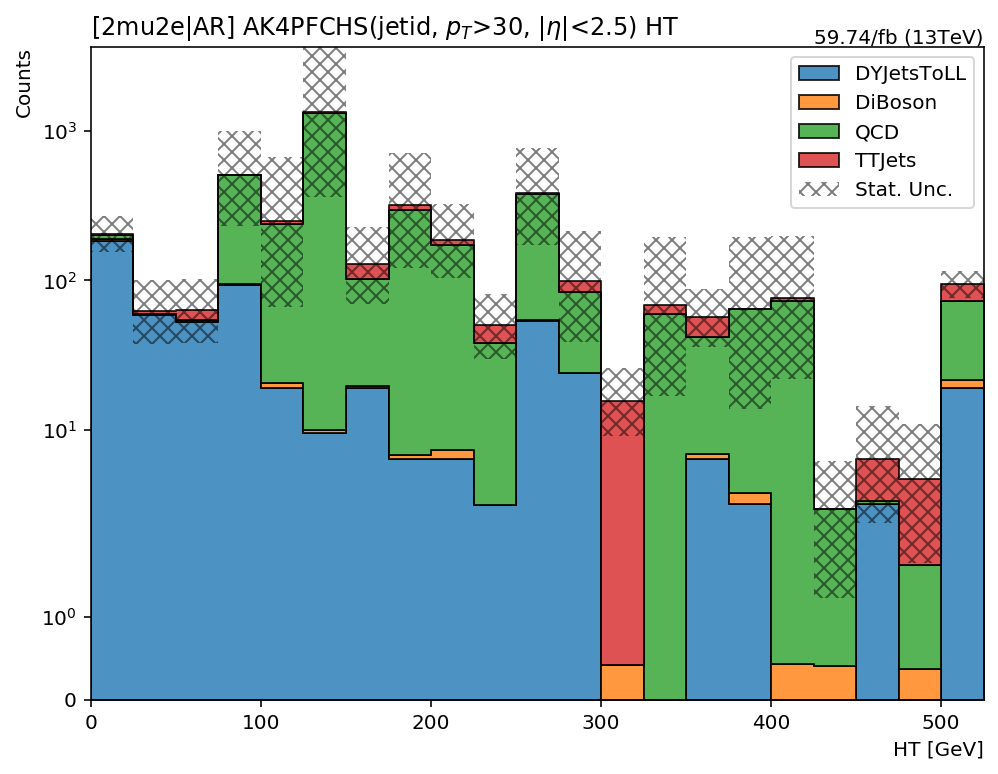

In [47]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) HT', x=0.0, ha="left");

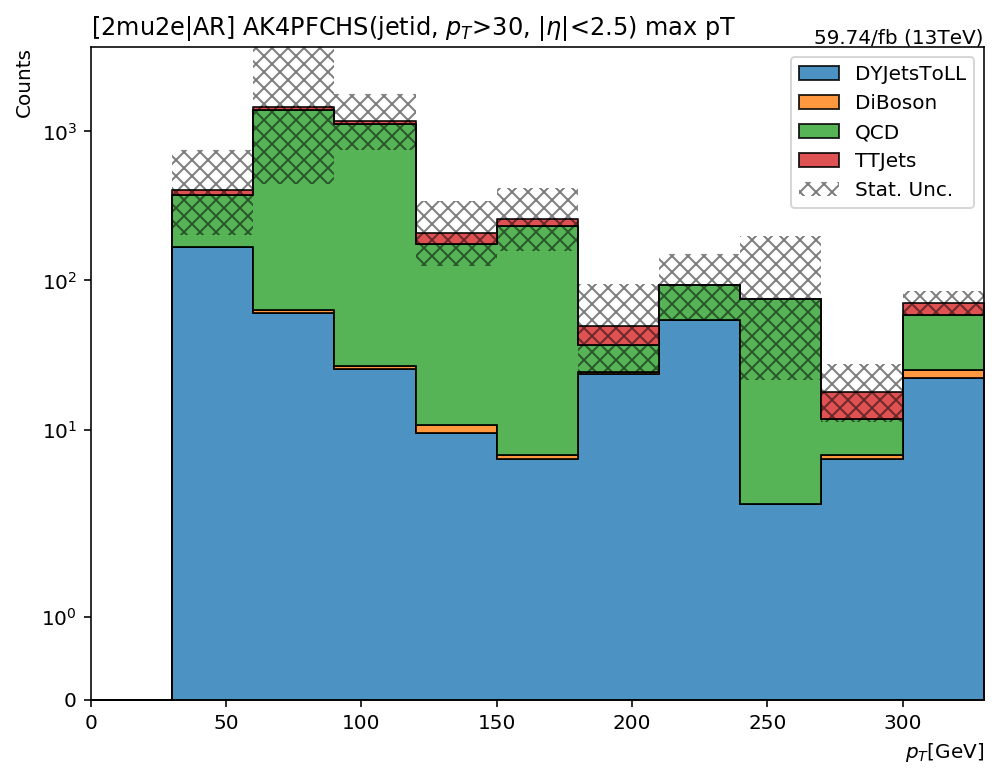

In [48]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) max pT', x=0.0, ha="left");

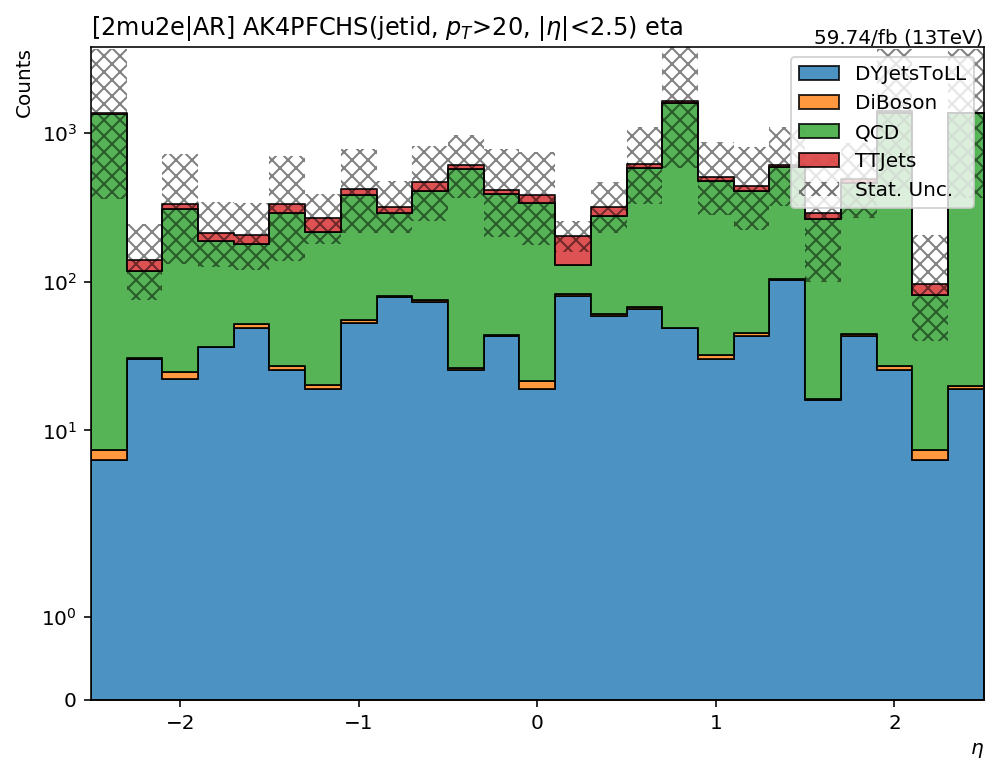

In [29]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['eta_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='none',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
# ax.vlines([-2.8, -2.6, 2.6, 2.8], 0, 1, transform=ax.get_xaxis_transform())
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>20, |$\eta$|<2.5) eta', x=0.0, ha="left");

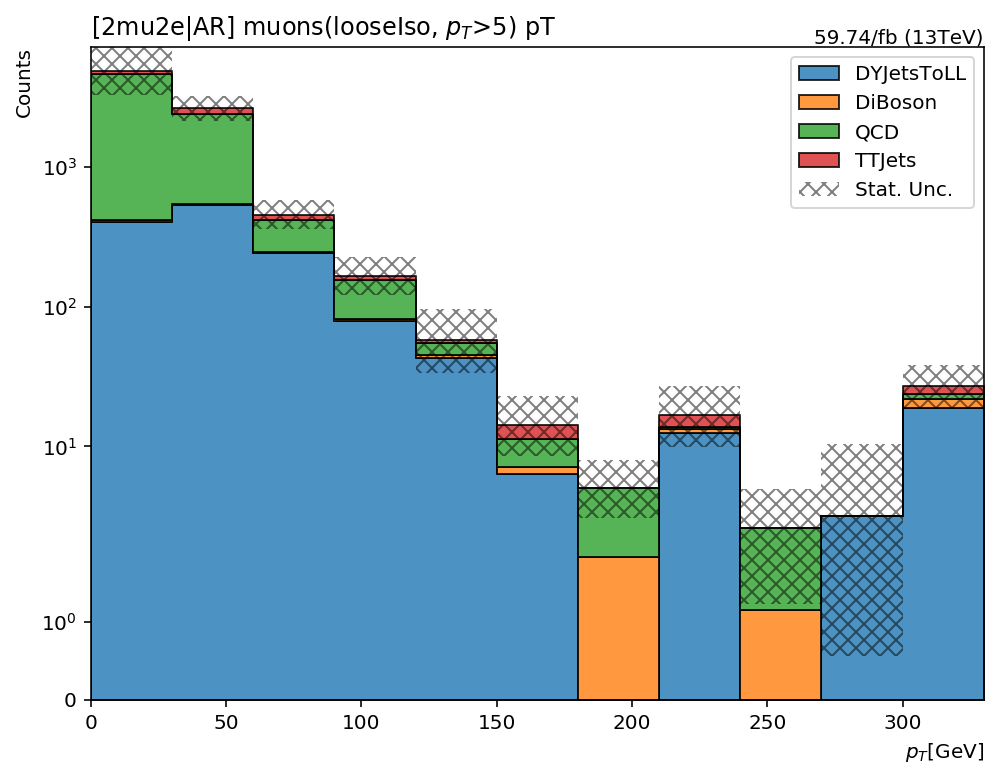

In [36]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['mupt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons(looseIso, $p_T$>5) pT', x=0.0, ha="left");

### PFIso

In [17]:
def plot_pfiso(var, chan, alias):
    if chan == '2mu2e':
        binslice = slice(1,2)
    if chan == '4mu':
        binslice = slice(2,3)
    fig, axes=plt.subplots(1,2, figsize=(16,6))
    hist.plot1d(output[var][notdata].integrate('channel', binslice).integrate('ljtype', 'egm'),
                       overlay='cat',
                       ax=axes[0],
                       clear=False,
                       stack=True,
                       overflow='none',
                       line_opts=None,
                       fill_opts=fill_opts,
                       error_opts=error_opts)
    hist.plot1d(output[var][notdata].integrate('channel', binslice).integrate('ljtype', 'mu'),
                       overlay='cat',
                       ax=axes[1],
                       clear=False,
                       stack=True,
                       overflow='none',
                       line_opts=None,
                       fill_opts=fill_opts,
                       error_opts=error_opts)
    for ax in axes:
        ax.autoscale(axis='both', tight=True)
        ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        # ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
        ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
    axes[0].set_title(f'[{chan}|AR] EGM-type leptonjet pfiso({alias})', x=0.0, ha="left")
    axes[1].set_title(f'[{chan}|AR] mu-type leptonjet pfiso({alias})', x=0.0, ha="left");

#### all PFCands

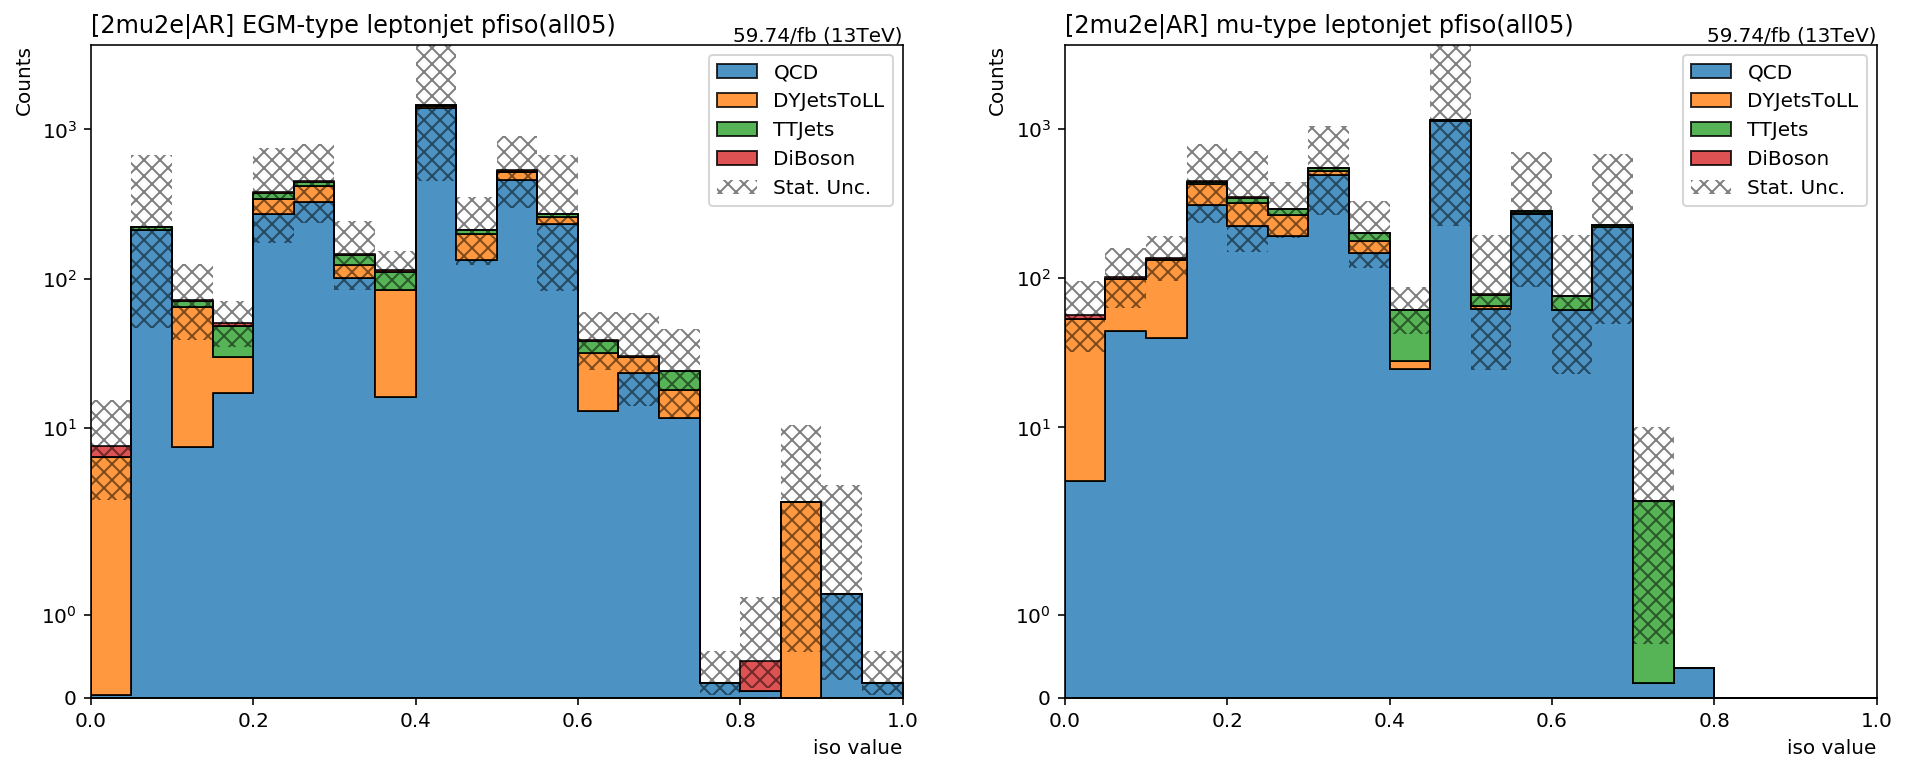

In [11]:
plot_pfiso('ljpfiso_all05_cat', '2mu2e', 'all05')

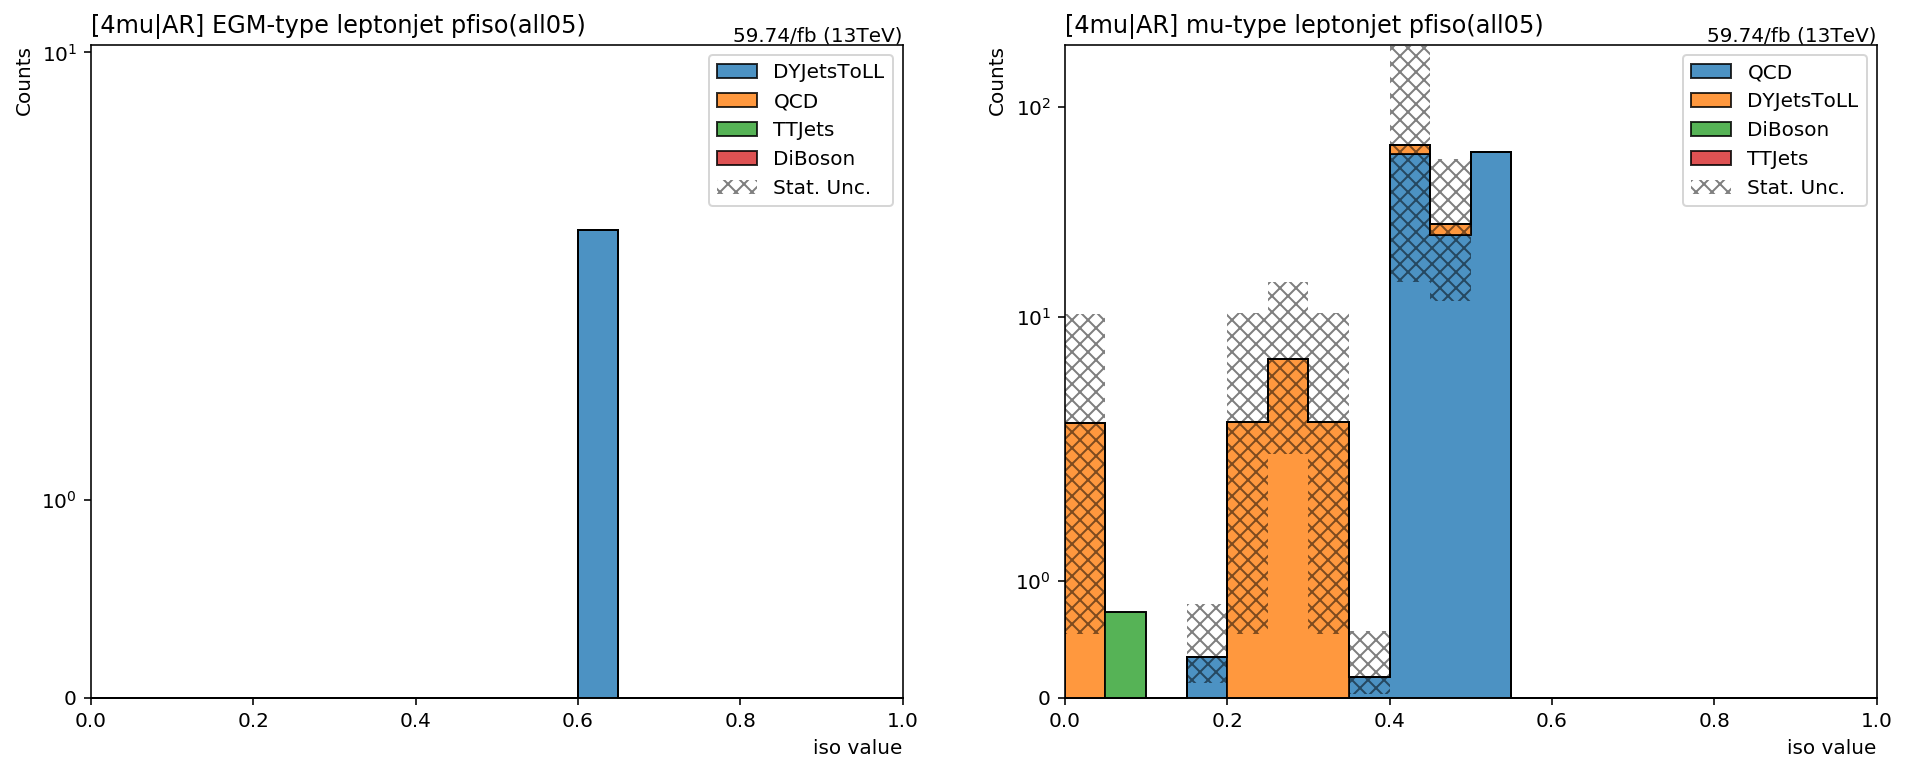

In [19]:
plot_pfiso('ljpfiso_all05_cat', '4mu', 'all05')

#### CHS

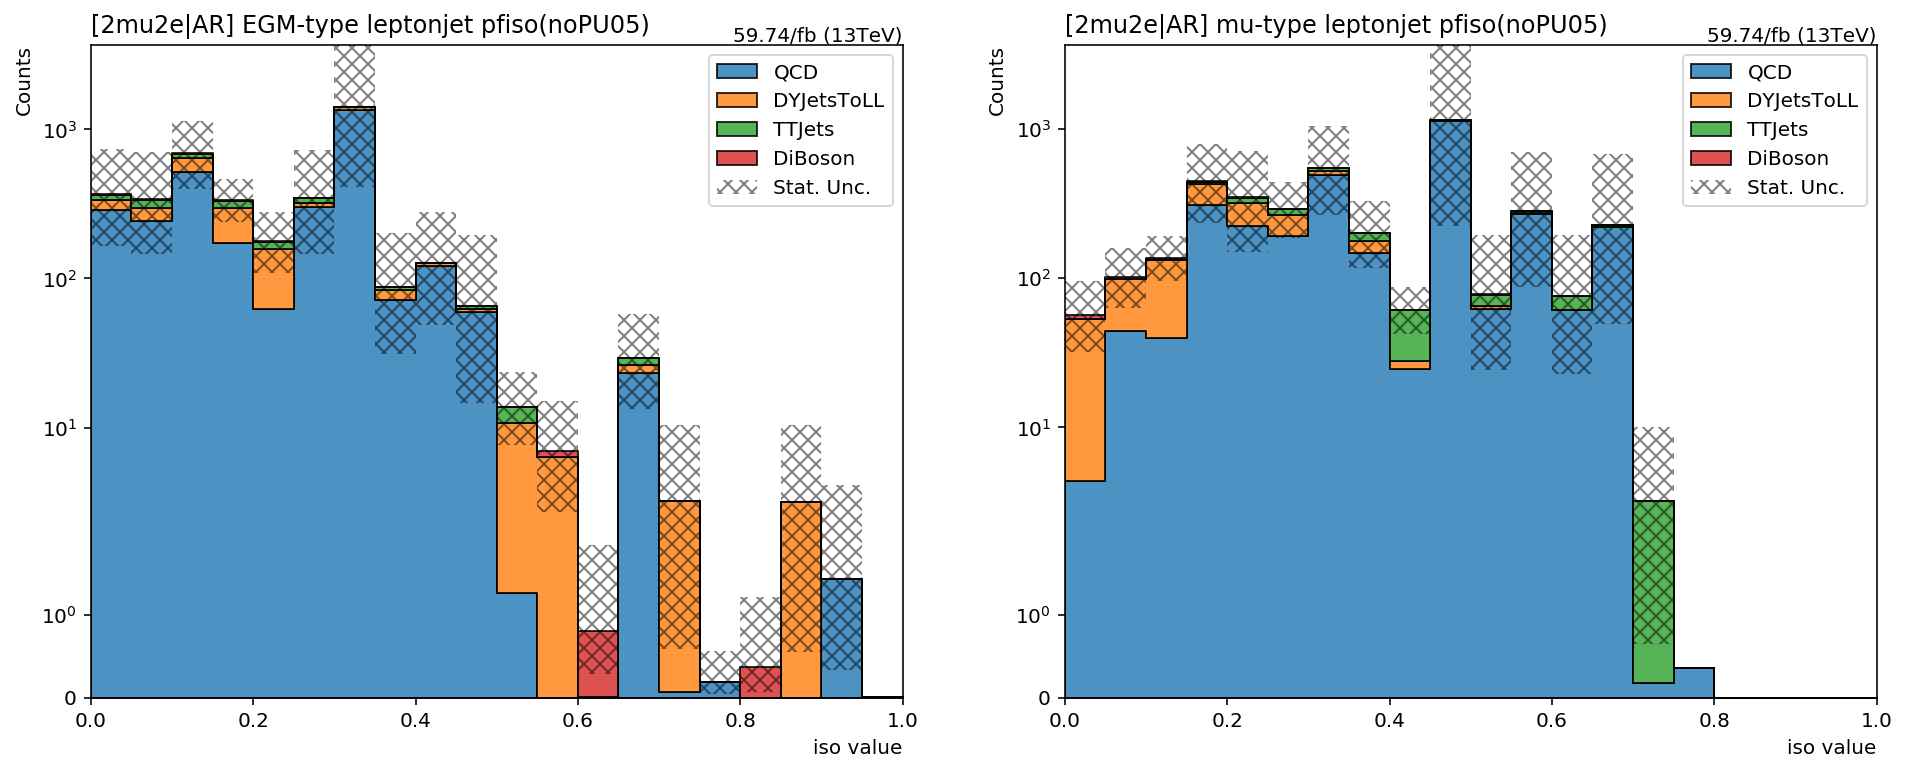

In [13]:
plot_pfiso('ljpfiso_nopu05_cat', chan='2mu2e', alias='noPU05')

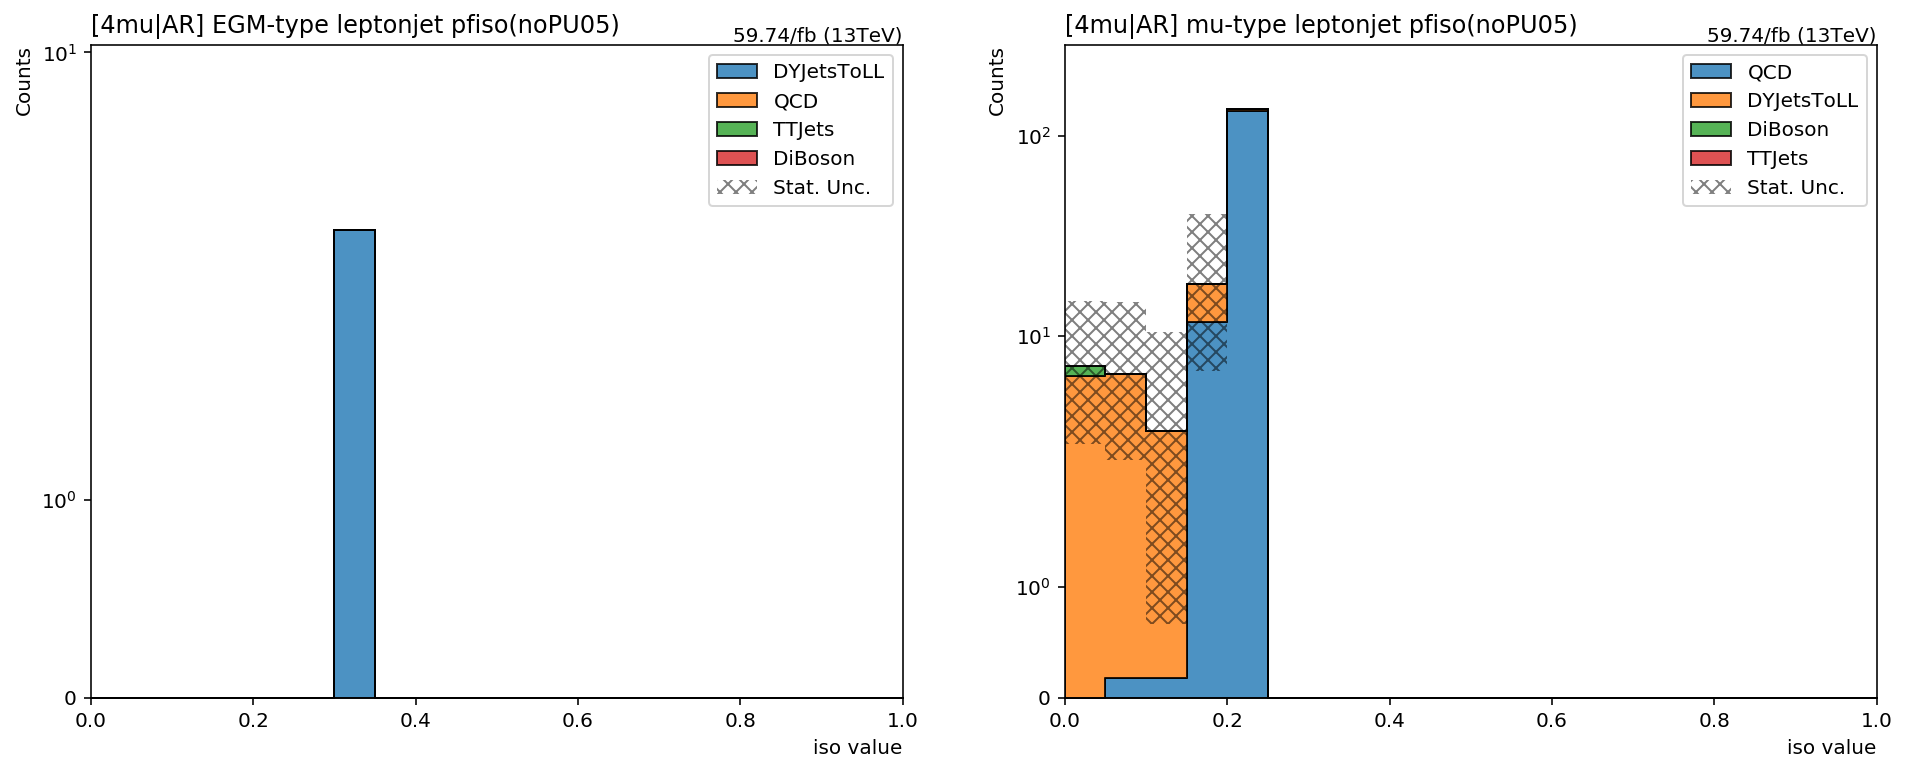

In [18]:
plot_pfiso('ljpfiso_nopu05_cat', chan='4mu', alias='noPU05')

#### $\Delta\beta$ PU correction

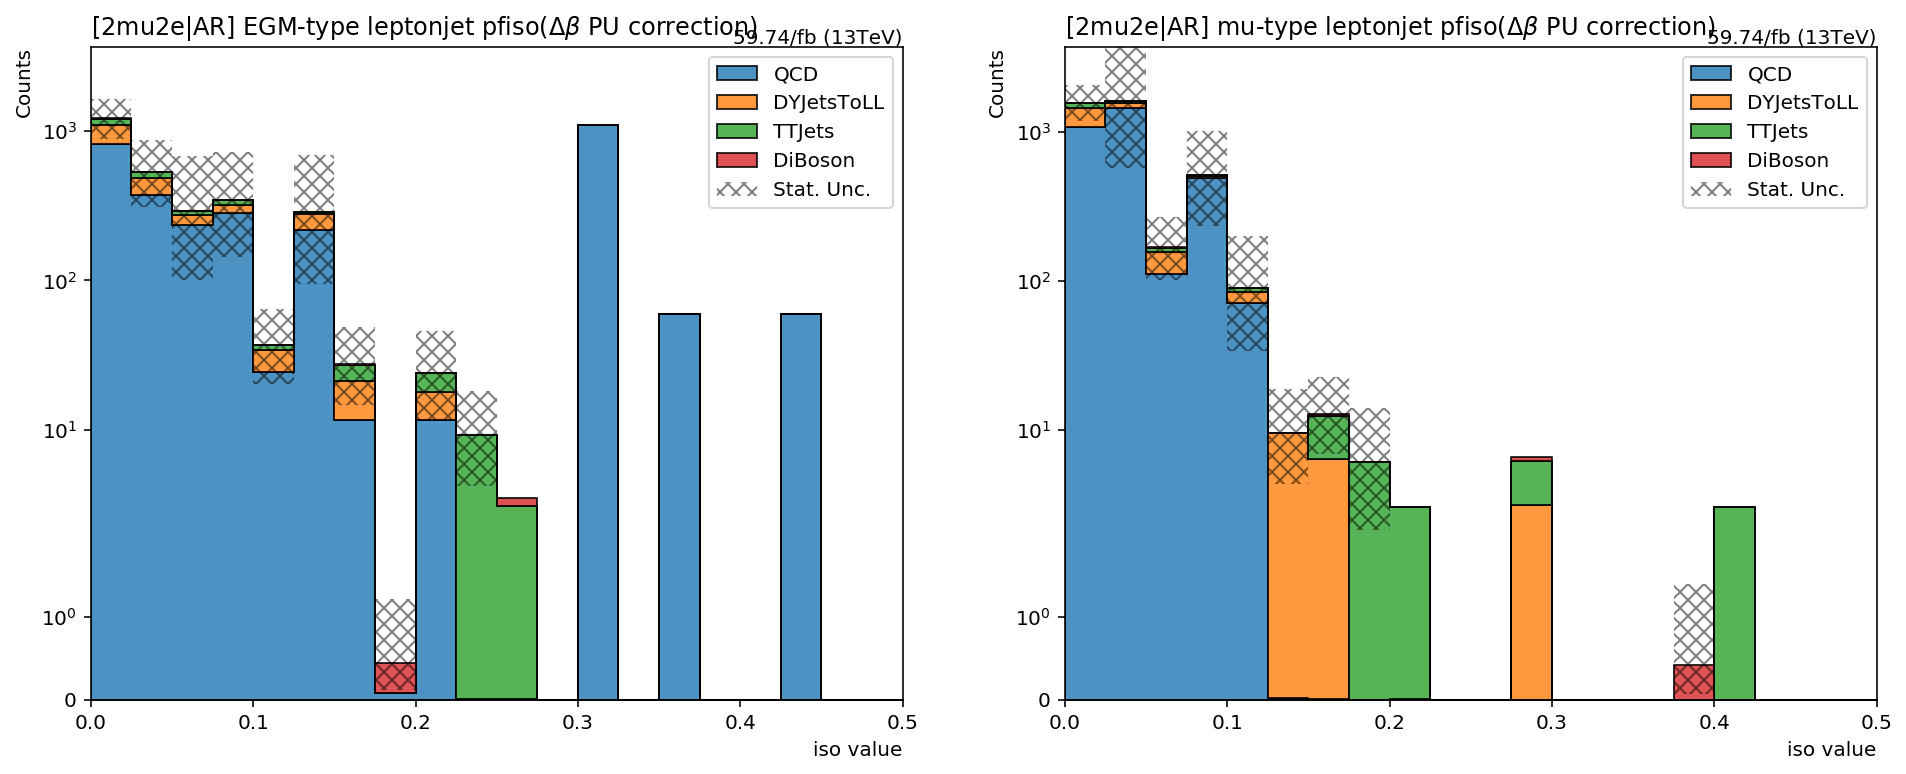

In [20]:
plot_pfiso('ljpfiso_dbeta_cat', chan='2mu2e', alias=r'$\Delta\beta$ PU correction')

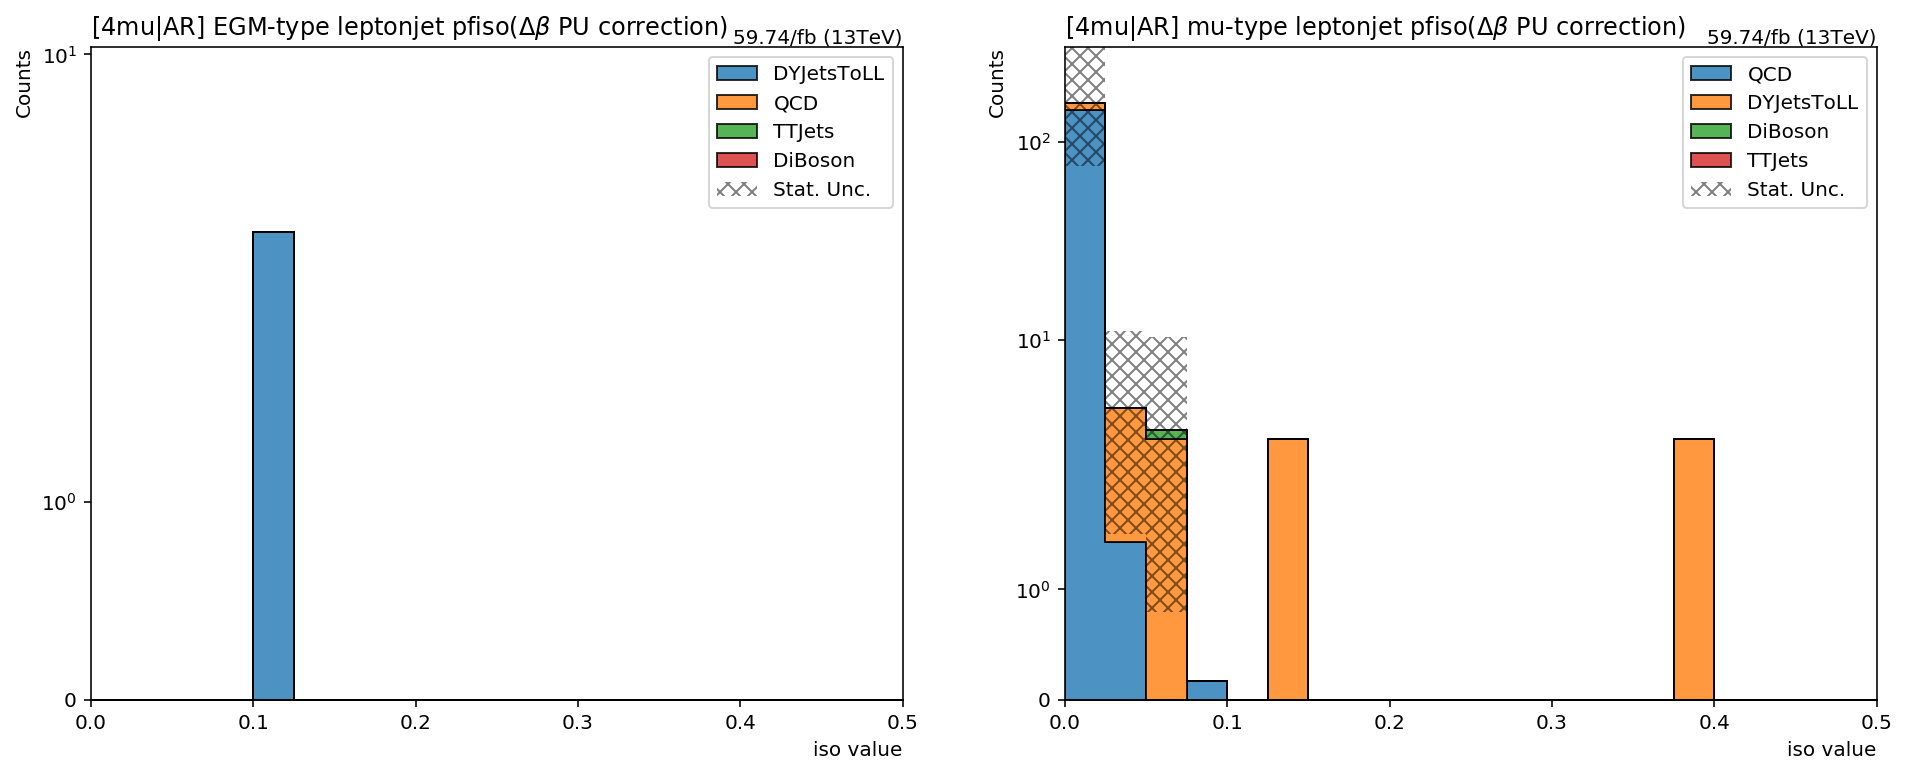

In [21]:
plot_pfiso('ljpfiso_dbeta_cat', chan='4mu', alias=r'$\Delta\beta$ PU correction')

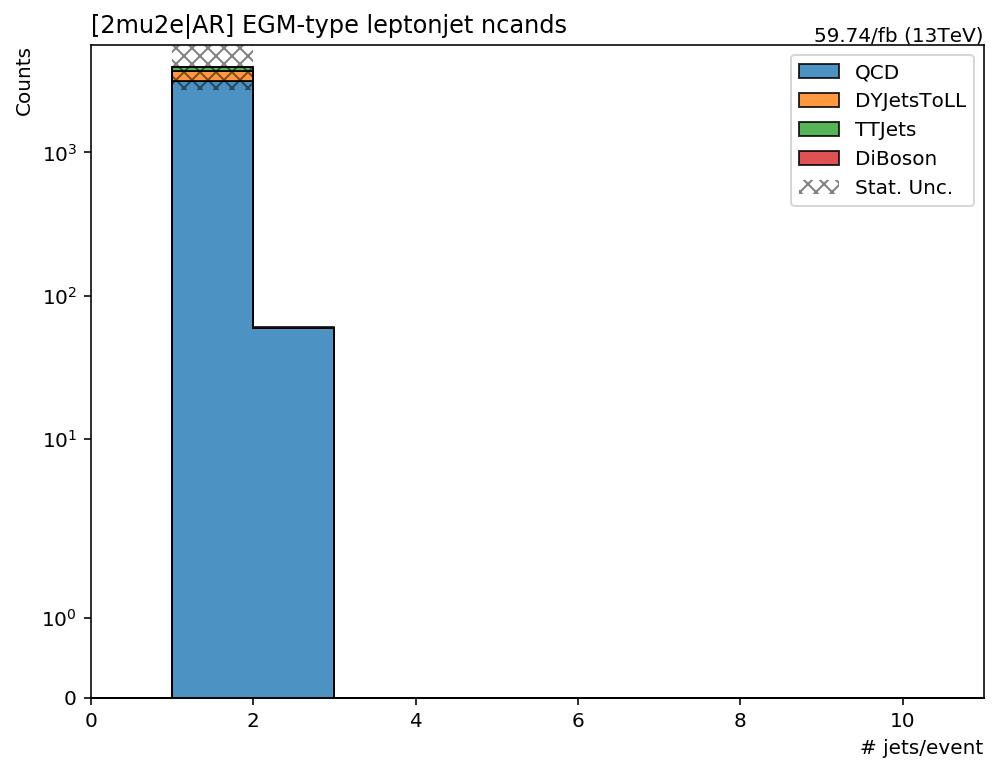

In [15]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands_cat'][notdata].integrate('channel', slice(1,2)).integrate('ljtype', 'egm'),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] EGM-type leptonjet ncands', x=0.0, ha="left");

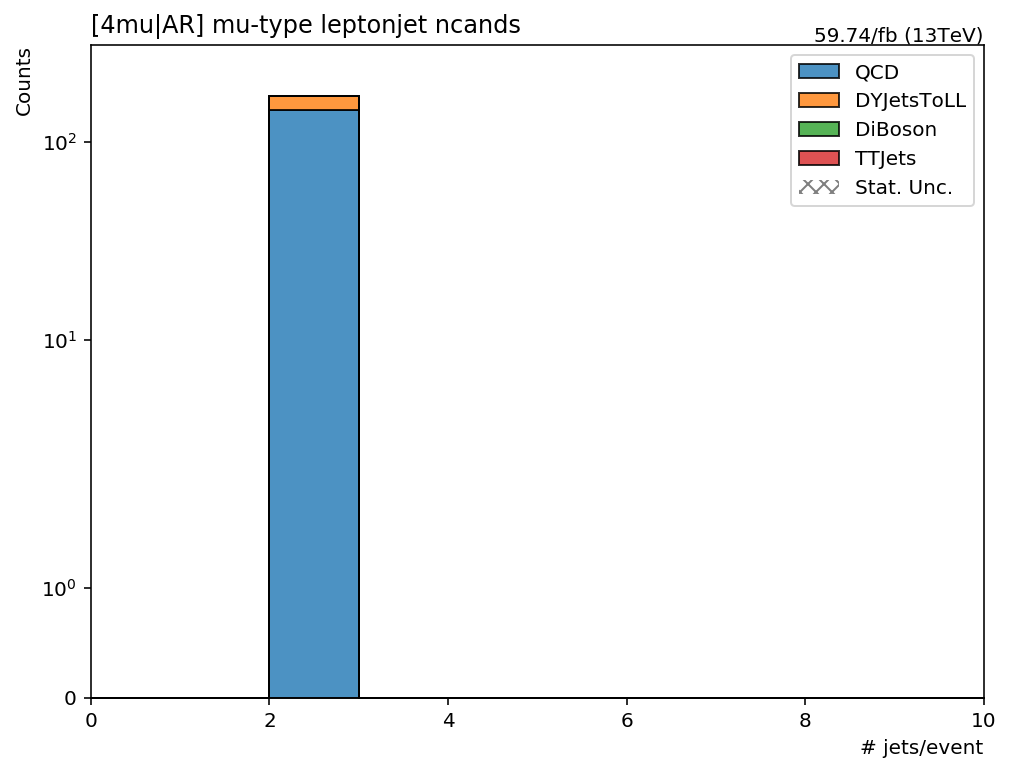

In [16]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands_cat'][notdata].integrate('channel', slice(2,3)).integrate('ljtype', 'mu'),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='none',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] mu-type leptonjet ncands', x=0.0, ha="left");

In [24]:

"""Leptonjet Isolation."""
class LeptonJetIsoProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "# jets/event", 10, 0, 10)
        lj0iso_axis = hist.Bin('lj0iso', 'iso value', 20, 0, 1)
        lj1iso_axis = hist.Bin('lj1iso', 'iso value', 20, 0, 1)
        siso_axis = hist.Bin('iso', 'iso value', 20, 0, 0.5)
        channel_axis = hist.Cat('channel', 'channel')
        type_axis = hist.Cat('isotype', 'isotype')
        
        self._accumulator = processor.dict_accumulator({
            'ljpfiso': hist.Hist('Counts', dataset_axis, lj0iso_axis, lj1iso_axis, type_axis, channel_axis)
        })
        
        ## NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfisoAll05=df['pfjet_pfIsolation05'],
            pfisoNopu05=df['pfjet_pfIsolationNoPU05'],
            pfisoDbeta=df['pfjet_pfiso'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        output['ljpfiso'].fill(dataset=dataset, lj0iso=lj0[channel_==2].pfisoAll05.flatten(), lj1iso=lj1[channel_==2].pfisoAll05.flatten(), weight=wgt[channel_==2], channel='4mu', isotype='all05')
        output['ljpfiso'].fill(dataset=dataset, lj0iso=lj0[channel_==2].pfisoNopu05.flatten(), lj1iso=lj1[channel_==2].pfisoNopu05.flatten(), weight=wgt[channel_==2], channel='4mu', isotype='nopu05')
        output['ljpfiso'].fill(dataset=dataset, lj0iso=lj0[channel_==2].pfisoDbeta.flatten(), lj1iso=lj1[channel_==2].pfisoDbeta.flatten(), weight=wgt[channel_==2], channel='4mu', isotype='dbeta')
    
        ## 2mu2e
        dileptonjets_2mu2e = dileptonjets[channel_==1]
        egm_2mu2e = dileptonjets_2mu2e[dileptonjets_2mu2e.iseltype]
        egm_2mu2e = egm_2mu2e[egm_2mu2e.pt.argmax()]
        mu_2mu2e = dileptonjets_2mu2e[dileptonjets_2mu2e.ismutype]
        mu_2mu2e = mu_2mu2e[mu_2mu2e.pt.argmax()]
        output['ljpfiso'].fill(dataset=dataset, lj0iso=egm_2mu2e.pfisoAll05.flatten(), lj1iso=mu_2mu2e.pfisoAll05.flatten(), weight=wgt[channel_==1], channel='2mu2e', isotype='all05')
        output['ljpfiso'].fill(dataset=dataset, lj0iso=egm_2mu2e.pfisoNopu05.flatten(), lj1iso=mu_2mu2e.pfisoNopu05.flatten(), weight=wgt[channel_==1], channel='2mu2e', isotype='nopu05')
        output['ljpfiso'].fill(dataset=dataset, lj0iso=egm_2mu2e.pfisoDbeta.flatten(), lj1iso=mu_2mu2e.pfisoDbeta.flatten(), weight=wgt[channel_==1], channel='2mu2e', isotype='dbeta')

        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets", sorting='integral'),
                                                         mapping)
        return accumulator

In [25]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetIsoProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

In [26]:
def plot_iso_2d(isotype):
    """isotype = all05/nopu05/dbeta"""
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    hist.plot2d(output['ljpfiso_cat'].sum('cat').integrate('channel', '2mu2e').integrate('isotype', isotype), xaxis='lj0iso', ax=axes[0], patch_opts=dict(norm=LogNorm()))
    hist.plot2d(output['ljpfiso_cat'].sum('cat').integrate('channel', '4mu').integrate('isotype', isotype), xaxis='lj0iso', ax=axes[1], patch_opts=dict(norm=LogNorm()))

    axes[0].set_title(f'[2mu2e] leptonJet isolation ({isotype})', x=0.0, ha="left")
    axes[0].set_xlabel('EGM-type lj isolation value')
    axes[0].set_ylabel('Mu-type lj isolation value')
    axes[1].set_title(f'[4mu] leptonJet isolation ({isotype})', x=0.0, ha="left")
    axes[1].set_xlabel('Mu-type lj0 isolation value')
    axes[1].set_ylabel('Mu-type lj1 isolation value')
    for ax in axes:
        ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

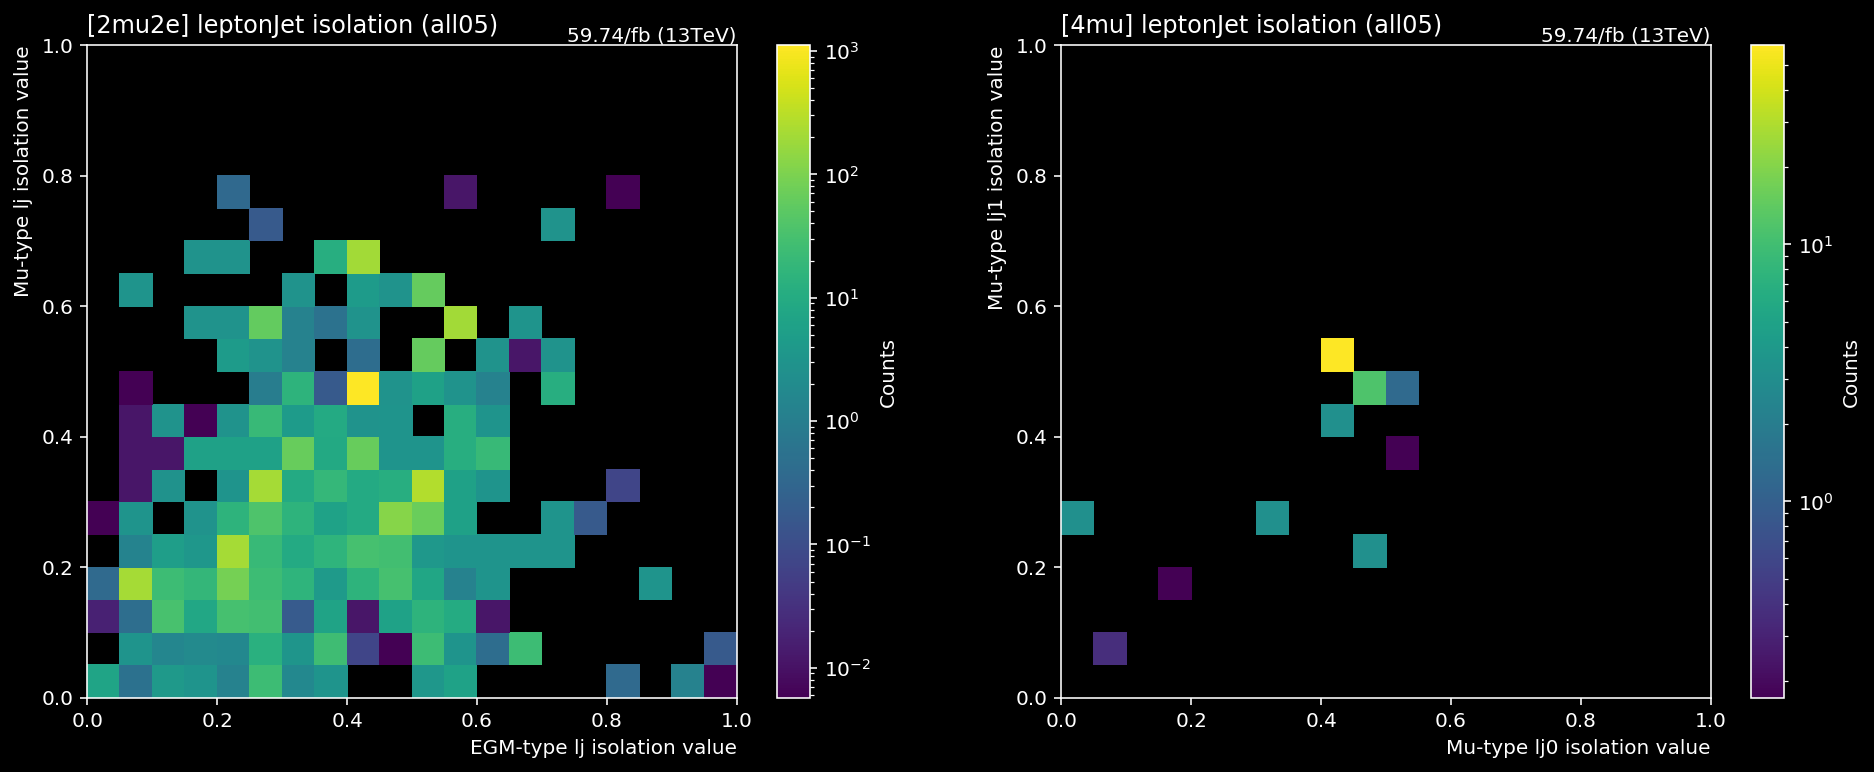

In [27]:
plot_iso_2d('all05')

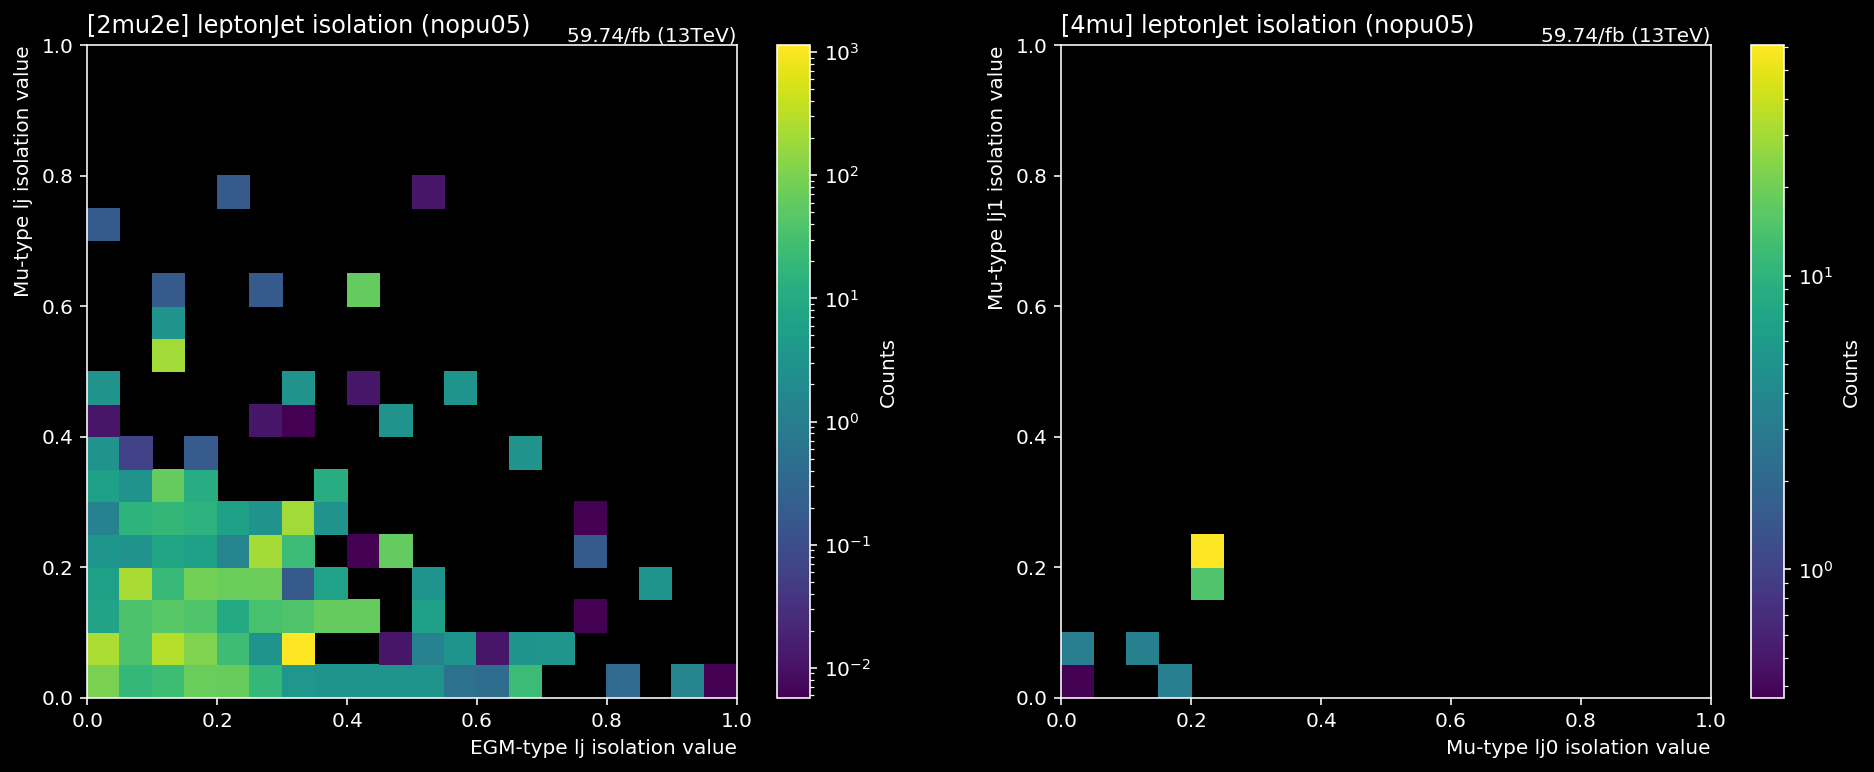

In [28]:
plot_iso_2d('nopu05')

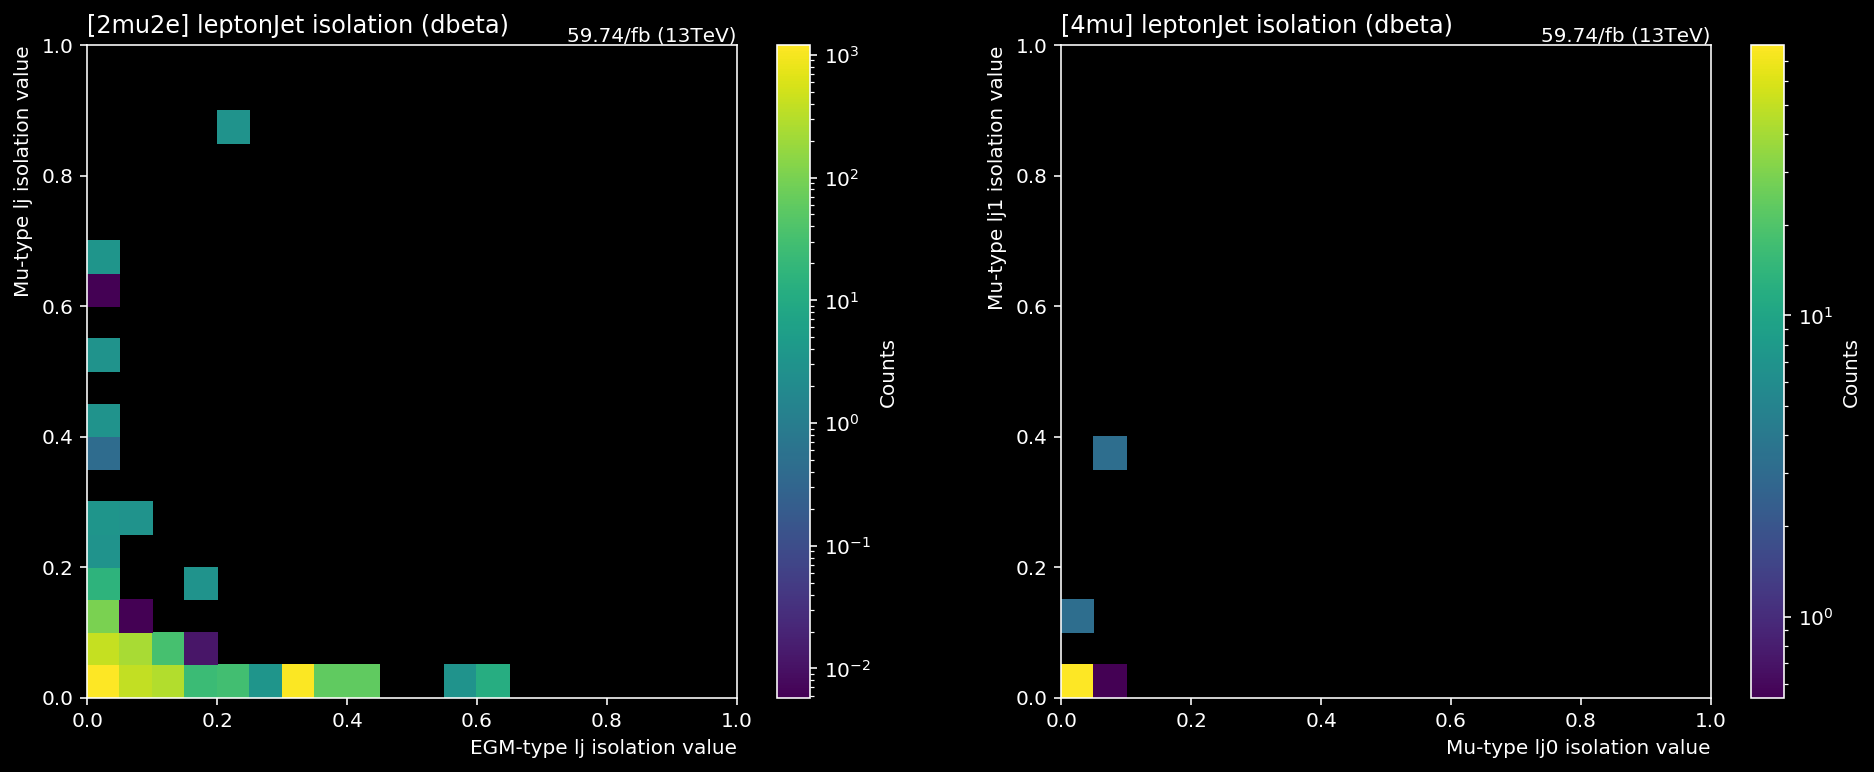

In [29]:
plot_iso_2d('dbeta')

# signal

In [32]:
dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))

In [33]:
"""AK4PFCHS multiplicy, HT, pT; EGM-type LJ pfiso; and more."""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'datasets')
        multiplicity_axis = hist.Bin("multiplicity", "# jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 10, 0, 300)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.5, 2.5)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 20, 0, 500)
        iso_axis = hist.Bin('iso', 'iso value', 20, 0, 1)
        siso_axis = hist.Bin('iso', 'iso value', 20, 0, 0.5)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        type_axis = hist.Cat('ljtype', 'ljtype')
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'eta': hist.Hist('Counts', dataset_axis, eta_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
            'nlj': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'ljpfiso_all05': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis, type_axis),
            'ljpfiso_nopu05': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis, type_axis),
            'ljpfiso_dbeta': hist.Hist('Counts', dataset_axis, siso_axis, channel_axis, type_axis),
            'ljcands': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis, type_axis),
            'nmuons': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'mupt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            
        })
        ## corrections, NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
#         if len(dataset)!=1:
#             wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            hadfrac=df['akjet_ak4PFJetsCHS_hadronEnergyFraction'],
            emfrac=df['akjet_ak4PFJetsCHS_emEnergyFraction'],
        )
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
            selector=df['muon_selectors']
        )
        muons.add_attributes(isoloose=np.bitwise_and(muons.selector, 1<<7)==(1<<7),
                             isomedium=np.bitwise_and(muons.selector, 1<<8)==(1<<8),
                             isotight=np.bitwise_and(muons.selector, 1<<9)==(1<<9),
                             idloose=np.bitwise_and(muons.selector, 1<<0)==(1<<0),
                             miniisoloose=np.bitwise_and(muons.selector, 1<<18)==(1<<18),
                            )

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfisoAll05=df['pfjet_pfIsolation05'],
            pfisoNopu05=df['pfjet_pfIsolationNoPU05'],
            pfisoDbeta=df['pfjet_pfiso'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        muons = muons[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        muons = muons
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>30)&(np.abs(ak4jets.eta)<2.5)]
        muons=muons[(muons.pt>5.)&(muons.isoloose)&muons.idloose]
        
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.jetid.sum(), weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        output['nmuons'].fill(dataset=dataset, multiplicity=muons.counts, weight=wgt, channel=channel_)
        
        mwgt = (muons.pt.ones_like()*wgt).flatten()
        mchannel = (muons.pt.ones_like()*channel_).flatten()
        output['mupt'].fill(dataset=dataset, pt=muons.pt.flatten(), weight=mwgt, channel=mchannel)
        
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.max().flatten(), weight=wgt, channel=channel_)
        output['eta'].fill(dataset=dataset, eta=ak4jets.eta.flatten(), weight=jwgt, channel=jchannel)
        
        ljwgt = (dileptonjets.pt.ones_like()*wgt).flatten()
        ljchannel=(dileptonjets.pt.ones_like()*channel_).flatten()
        output['nlj'].fill(dataset=dataset, multiplicity=dileptonjets.counts, weight=wgt, channel=channel_)
        
        
        egammalj = dileptonjets[dileptonjets.iseltype] # `iseltype`
        egwgt = (egammalj.pt.ones_like()*wgt).flatten()
        egchannel = (egammalj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=egammalj.ncands.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_all05'].fill(dataset=dataset, iso=egammalj.pfisoAll05.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_nopu05'].fill(dataset=dataset, iso=egammalj.pfisoNopu05.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        output['ljpfiso_dbeta'].fill(dataset=dataset, iso=egammalj.pfisoDbeta.flatten(), weight=egwgt, channel=egchannel, ljtype='egm')
        
        mulj = dileptonjets[dileptonjets.ismutype]
        muljwgt = (mulj.pt.ones_like()*wgt).flatten()
        muljchannel = (mulj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=mulj.ncands.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_all05'].fill(dataset=dataset, iso=mulj.pfisoAll05.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_nopu05'].fill(dataset=dataset, iso=mulj.pfisoNopu05.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        output['ljpfiso_dbeta'].fill(dataset=dataset, iso=mulj.pfisoDbeta.flatten(), weight=muljwgt, channel=muljchannel, ljtype='mu')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [34]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

In [36]:
def left_right_sig(hist, axis, cut):
    for d in hist.identifiers('dataset'):
        print(f'[{str(d):30}]', end='  ')
        h = hist.integrate('dataset', d)
        edges_ = h.axis(axis).edges()
        low, high = edges_[0], edges_[-1]
        leftVal = h.integrate(axis, slice(low, cut)).values()[()]
        rightVal = h.integrate(axis, slice(cut, high)).values()[()]
        totalVal = h.integrate(axis, slice(low, high)).values()[()]
        print(f'<{cut}:\t{leftVal:.2f}/{totalVal:.2f}\t{leftVal/totalVal*100:.2f}%', end='\t|  ')
        print(f'>{cut}:\t{rightVal:.2f}/{totalVal:.2f}\t{rightVal/totalVal*100:.2f}%')
    print('+'*90)

h = output['njets']['2mu2e/*'].integrate('channel', slice(1,2))
ax = 'multiplicity'
left_right_sig(h, ax, 3)
left_right_sig(h, ax, 4)

u2e/mXX-1000_mA-0p25_lxy-0p3]  <3:	3103.00/3249.00	95.51%	|  >3:	146.00/3249.00	4.49%
u2e/mXX-1000_mA-0p25_lxy-300]  <3:	117.00/119.00	98.32%	|  >3:	2.00/119.00	1.68%
u2e/mXX-100_mA-5_lxy-0p3    ]  <3:	327.00/330.00	99.09%	|  >3:	3.00/330.00	0.91%
u2e/mXX-100_mA-5_lxy-300    ]  <3:	10.00/10.00	100.00%	|  >3:	0.00/10.00	0.00%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
u2e/mXX-1000_mA-0p25_lxy-0p3]  <4:	3219.00/3249.00	99.08%	|  >4:	30.00/3249.00	0.92%
u2e/mXX-1000_mA-0p25_lxy-300]  <4:	119.00/119.00	100.00%	|  >4:	0.00/119.00	0.00%
u2e/mXX-100_mA-5_lxy-0p3    ]  <4:	329.00/330.00	99.70%	|  >4:	1.00/330.00	0.30%
u2e/mXX-100_mA-5_lxy-300    ]  <4:	10.00/10.00	100.00%	|  >4:	0.00/10.00	0.00%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


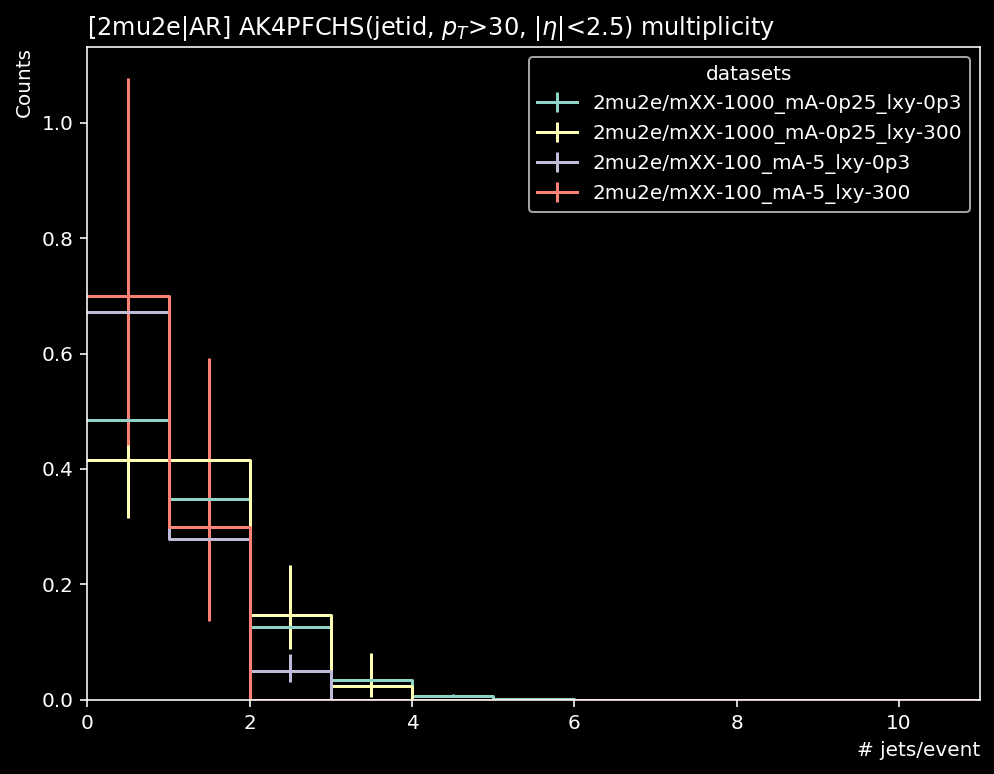

In [35]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['njets']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) multiplicity', x=0.0, ha="left");

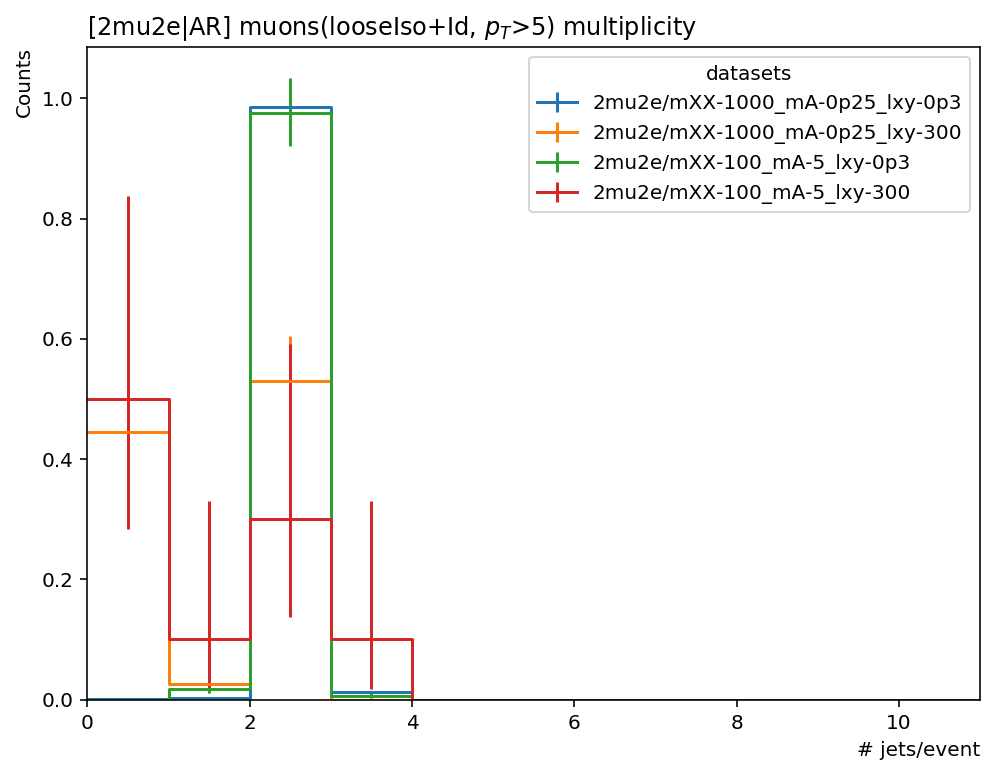

In [40]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['nmuons']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons(looseIso+Id, $p_T$>5) multiplicity', x=0.0, ha="left");

In [38]:
h = output['ht']['2mu2e/*'].integrate('channel', slice(1,2))
ax = 'ht'
left_right_sig(h, ax, 200)
left_right_sig(h, ax, 300)

u2e/mXX-1000_mA-0p25_lxy-0p3]  <200:	2917.00/3196.00	91.27%	|  >200:	279.00/3196.00	8.73%
u2e/mXX-1000_mA-0p25_lxy-300]  <200:	111.00/119.00	93.28%	|  >200:	8.00/119.00	6.72%
u2e/mXX-100_mA-5_lxy-0p3    ]  <200:	330.00/330.00	100.00%	|  >200:	0.00/330.00	0.00%
u2e/mXX-100_mA-5_lxy-300    ]  <200:	10.00/10.00	100.00%	|  >200:	0.00/10.00	0.00%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
u2e/mXX-1000_mA-0p25_lxy-0p3]  <300:	3083.00/3196.00	96.46%	|  >300:	113.00/3196.00	3.54%
u2e/mXX-1000_mA-0p25_lxy-300]  <300:	116.00/119.00	97.48%	|  >300:	3.00/119.00	2.52%
u2e/mXX-100_mA-5_lxy-0p3    ]  <300:	330.00/330.00	100.00%	|  >300:	0.00/330.00	0.00%
u2e/mXX-100_mA-5_lxy-300    ]  <300:	10.00/10.00	100.00%	|  >300:	0.00/10.00	0.00%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


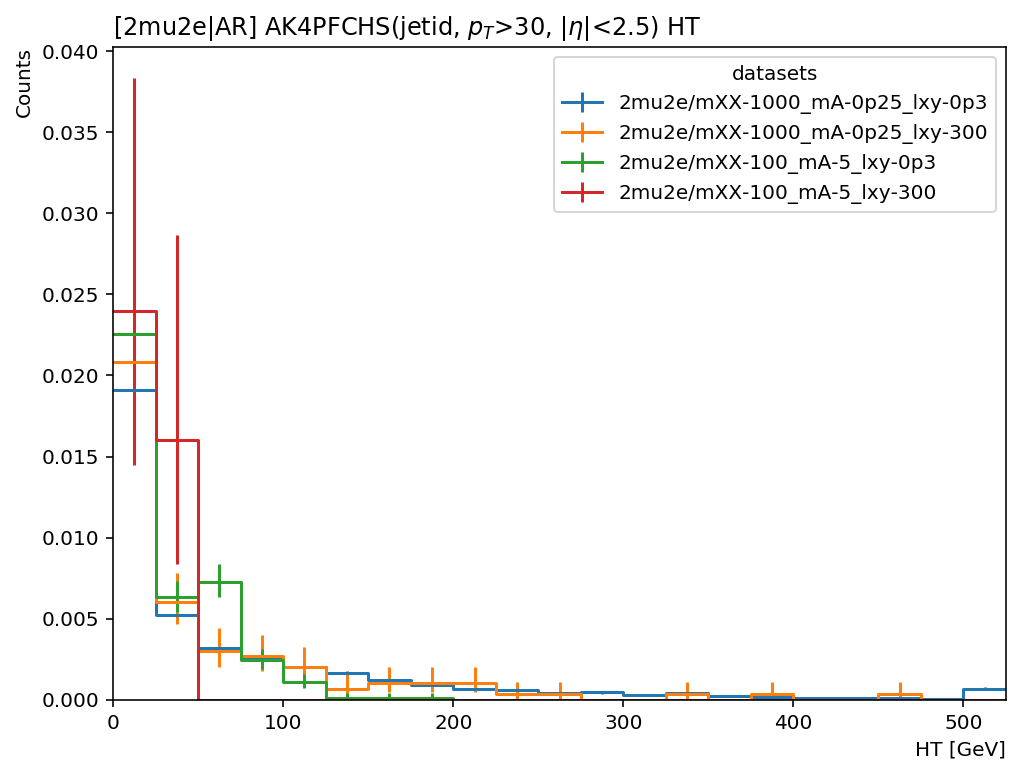

In [37]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) HT', x=0.0, ha="left");

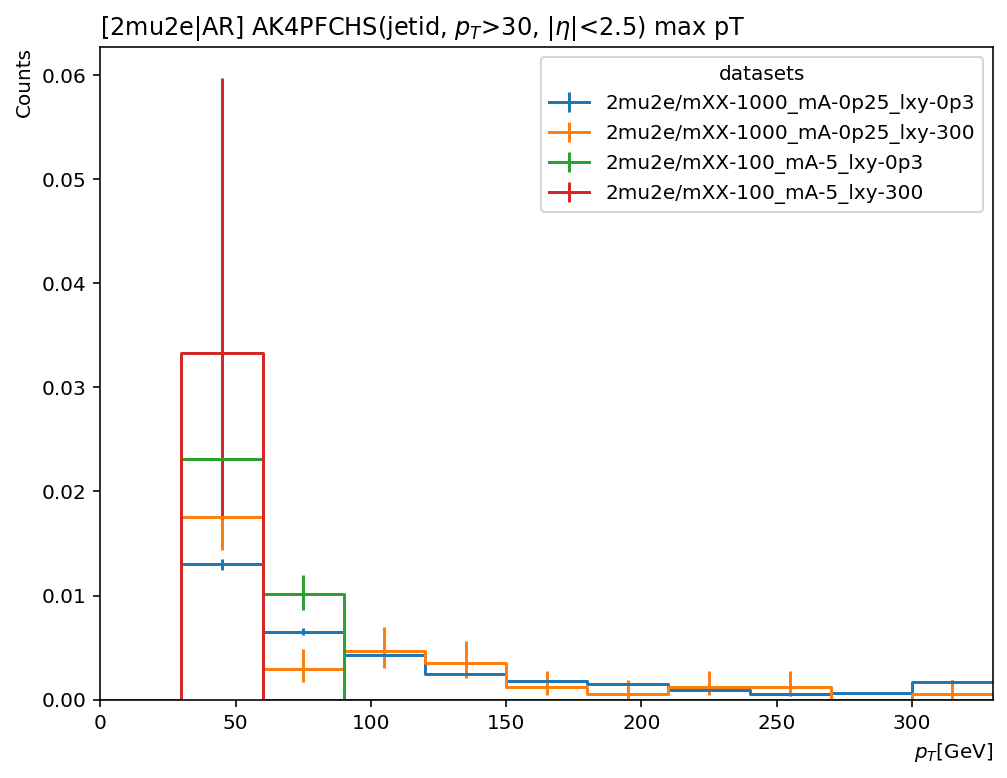

In [39]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) max pT', x=0.0, ha="left");

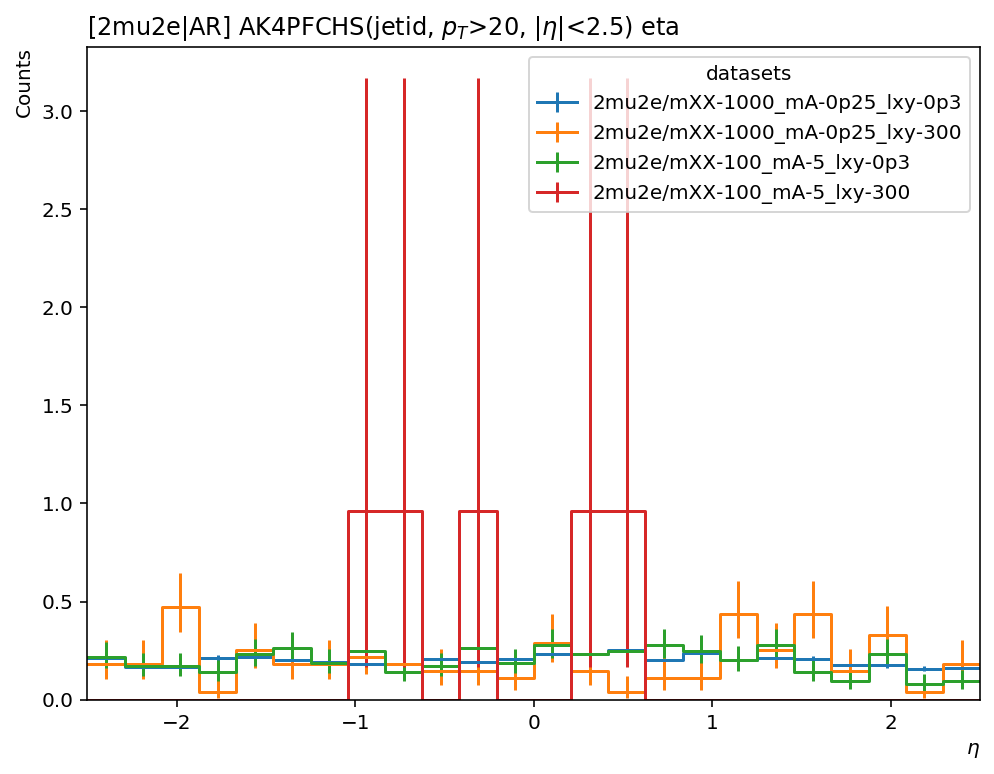

In [44]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['eta']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='none',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS(jetid, $p_T$>20, |$\eta$|<2.5) eta', x=0.0, ha="left");

### PFIso

In [27]:
def plot_pfiso_sig(var, chan, alias):
    if chan == '2mu2e':
        binslice = slice(1,2)
    if chan == '4mu':
        binslice = slice(2,3)
    fig, axes=plt.subplots(1,2, figsize=(16,6))
    hist.plot1d(output[var][f'{chan}/*'].integrate('channel', binslice).integrate('ljtype', 'egm'),
                       overlay='dataset',
                       ax=axes[0],
                       density=True,
                       overflow='over',)
    hist.plot1d(output[var][f'{chan}/*'].integrate('channel', binslice).integrate('ljtype', 'mu'),
                       overlay='dataset',
                       ax=axes[1],
                       density=True,
                       overflow='over',)
    for ax in axes:
        # ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        # ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
    axes[0].set_title(f'[{chan}|AR] EGM-type leptonjets pfiso({alias})', x=0.0, ha="left")
    axes[1].set_title(f'[{chan}|AR] mu-type leptonjets pfiso({alias})', x=0.0, ha="left");

#### all PFCands

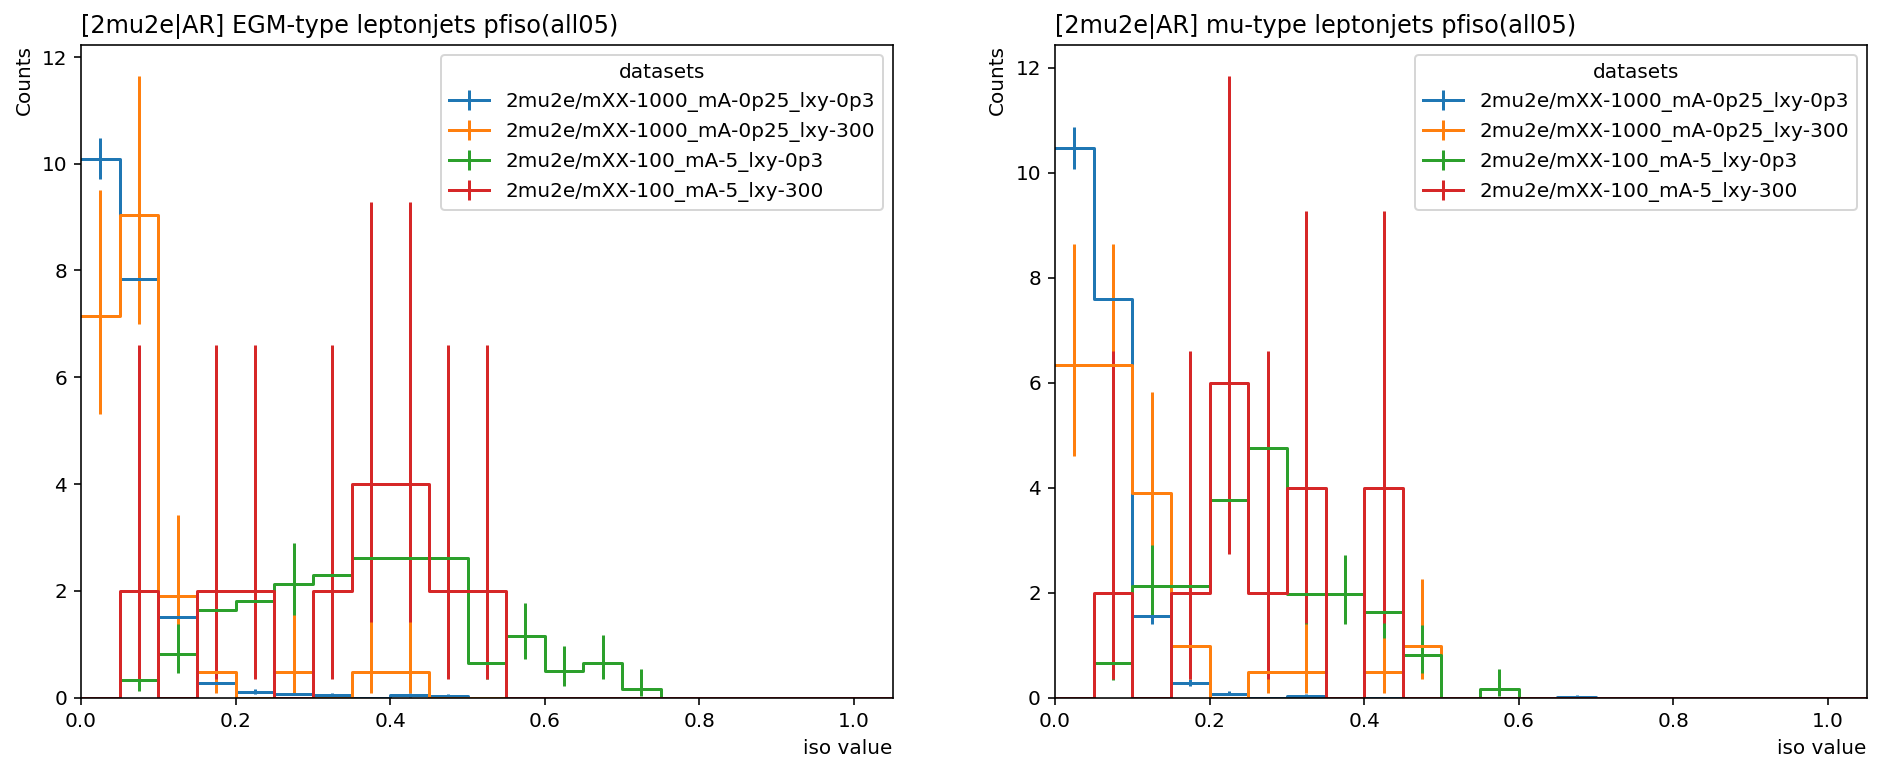

In [28]:
plot_pfiso_sig('ljpfiso_all05', chan='2mu2e', alias='all05')

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


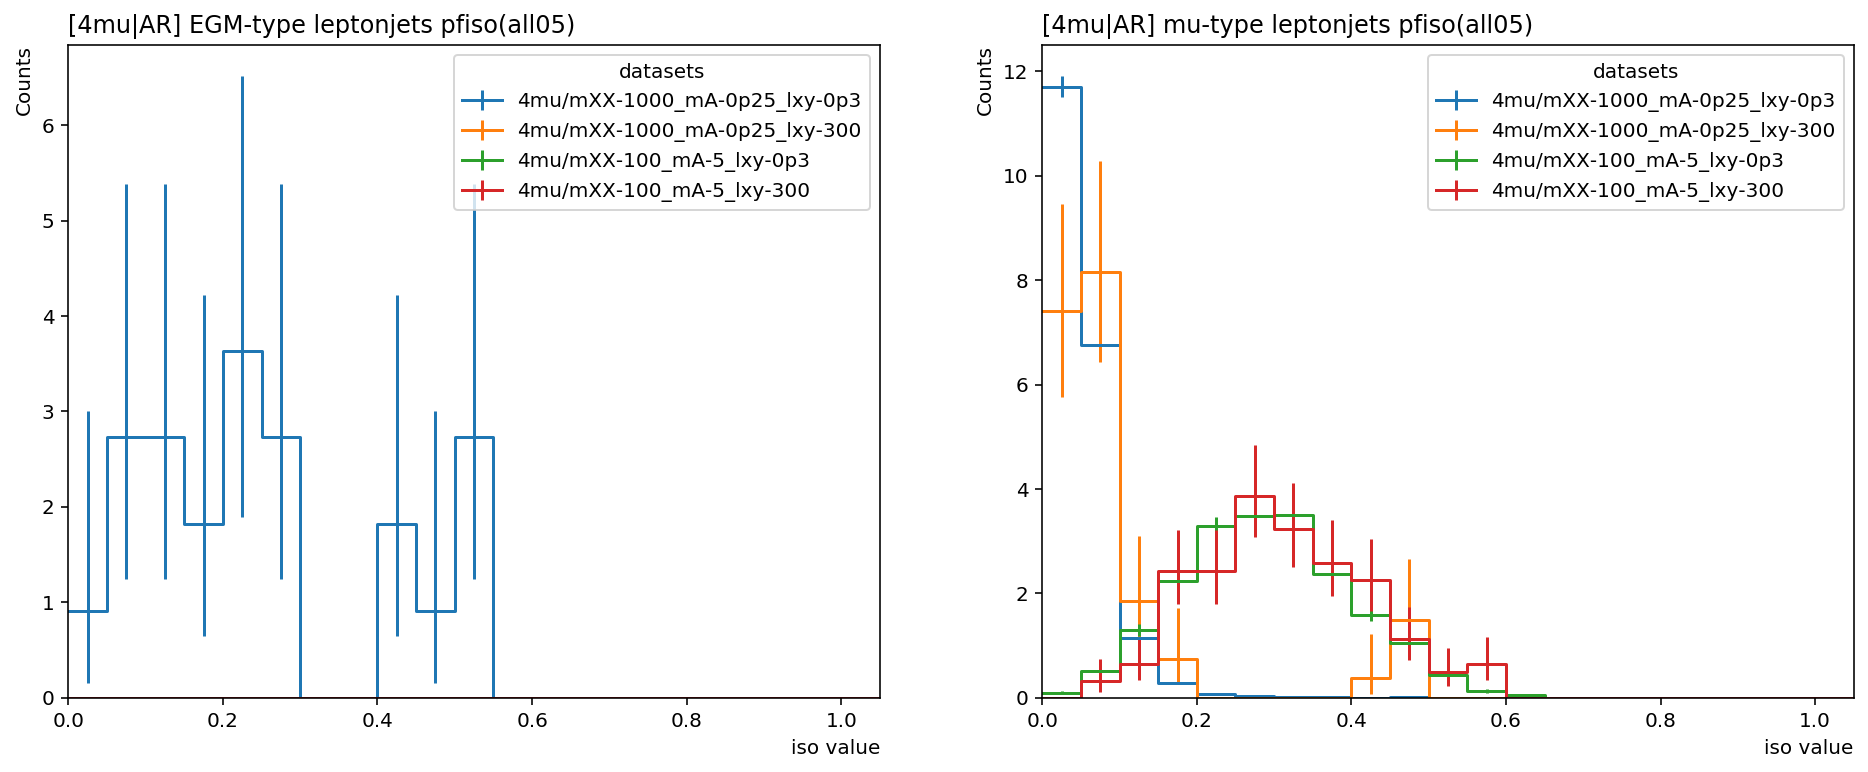

In [29]:
plot_pfiso_sig('ljpfiso_all05', chan='4mu', alias='all05')

#### CHS

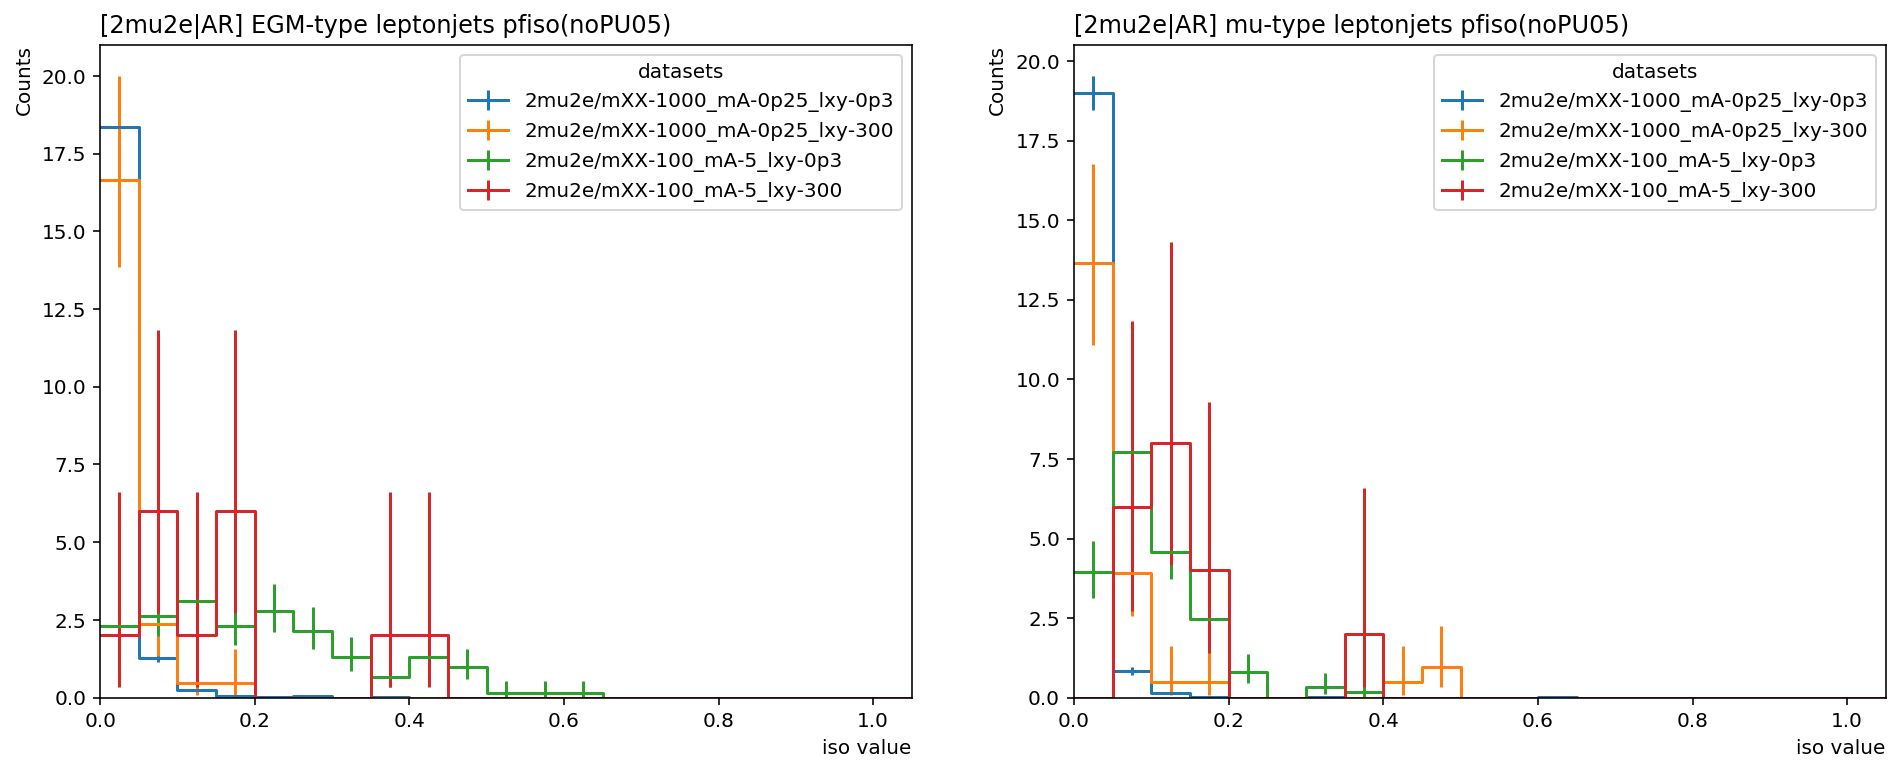

In [30]:
plot_pfiso_sig('ljpfiso_nopu05', chan='2mu2e', alias='noPU05')

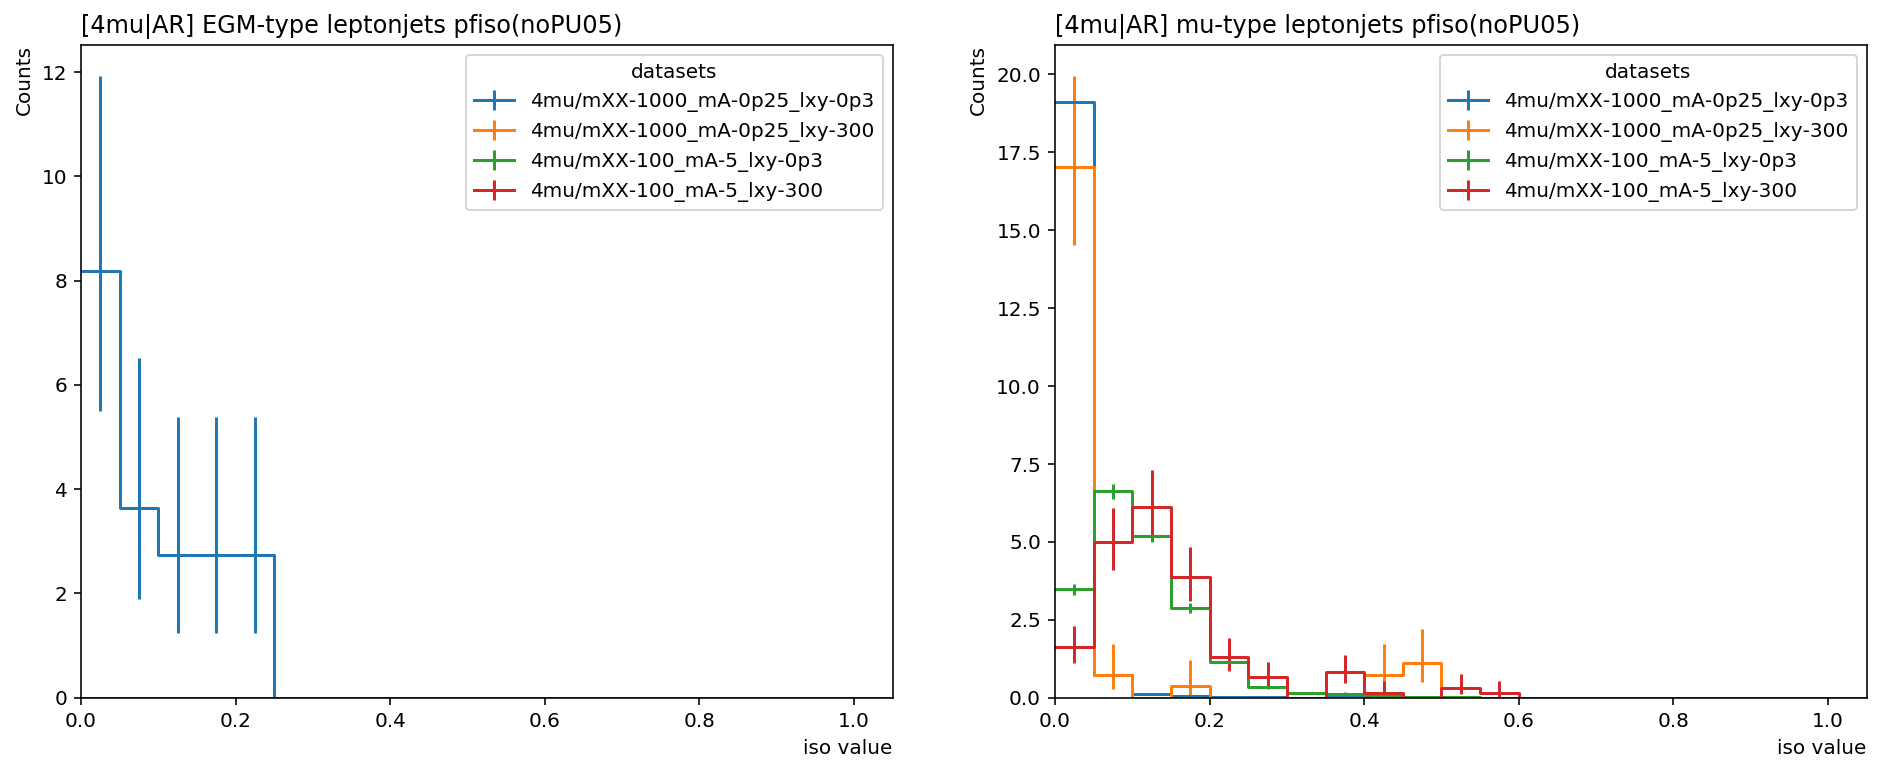

In [31]:
plot_pfiso_sig('ljpfiso_nopu05', chan='4mu', alias='noPU05')

#### $\Delta\beta$ PU correction

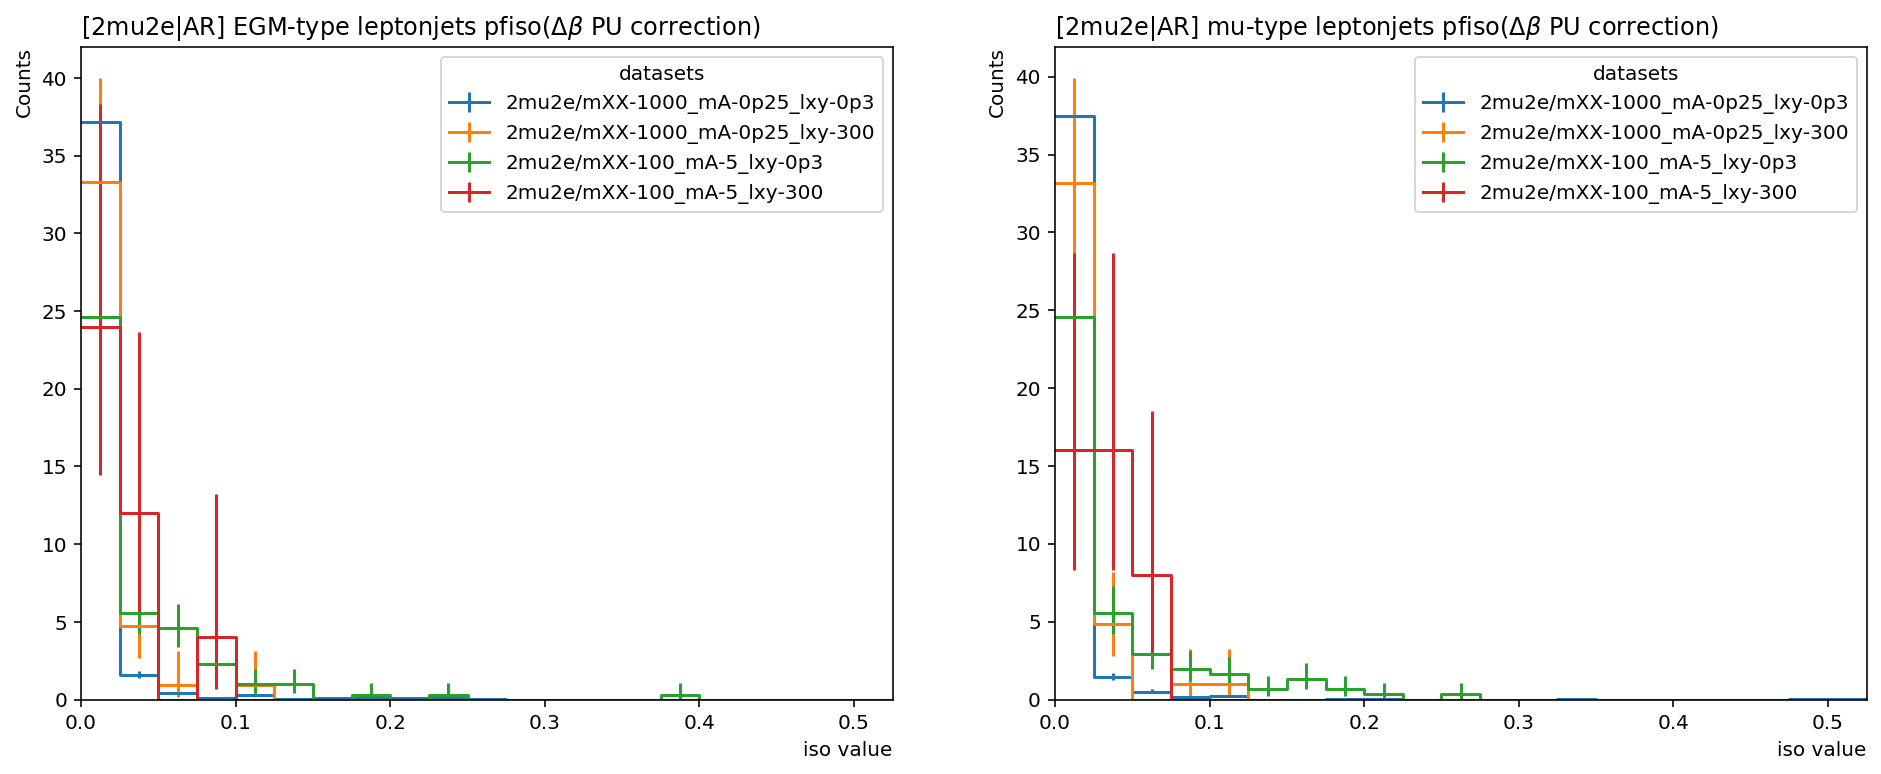

In [32]:
plot_pfiso_sig('ljpfiso_dbeta', chan='2mu2e', alias=r'$\Delta\beta$ PU correction')

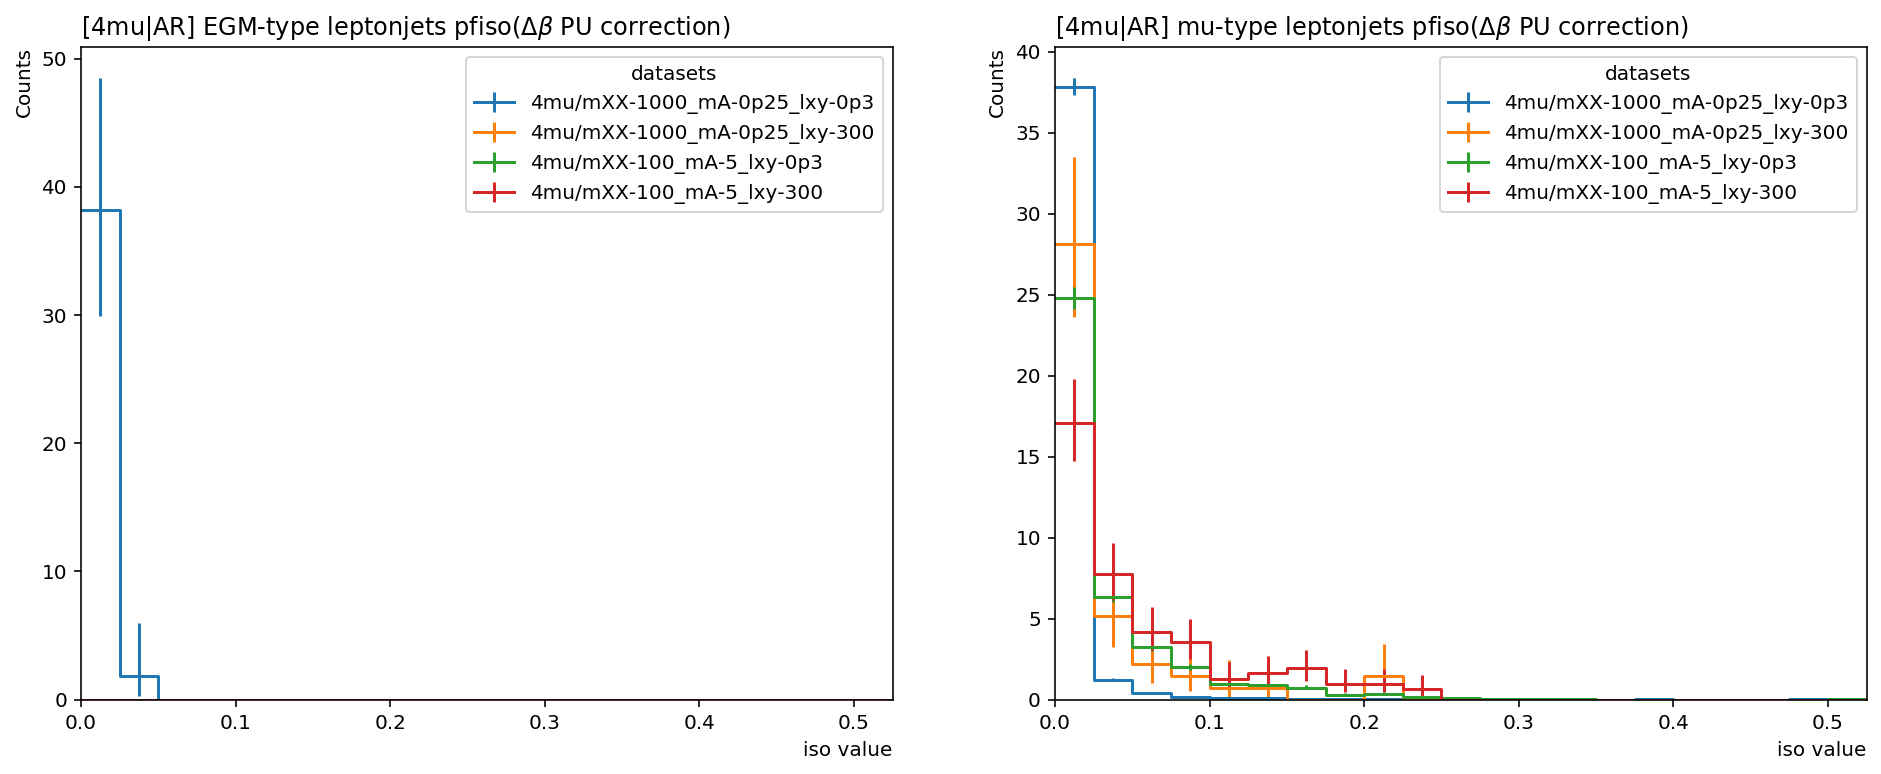

In [33]:
plot_pfiso_sig('ljpfiso_dbeta', chan='4mu', alias=r'$\Delta\beta$ PU correction')

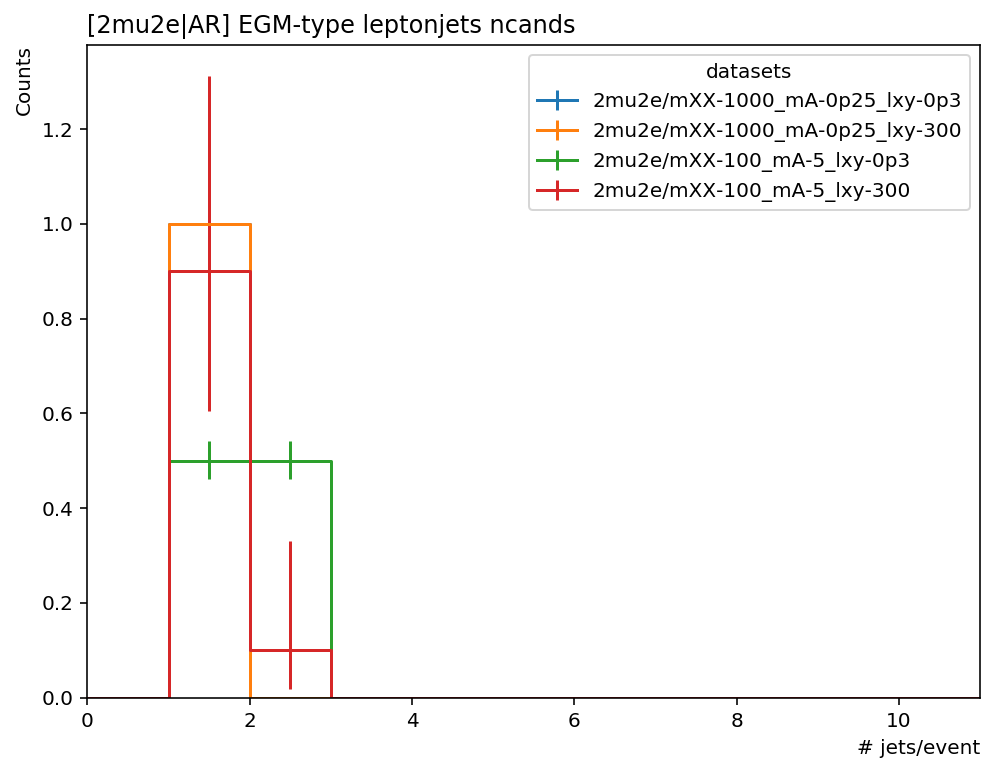

In [50]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands']['2mu2e/*'].integrate('channel', slice(1,2)).integrate('ljtype', 'egm'),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] EGM-type leptonjets ncands', x=0.0, ha="left");

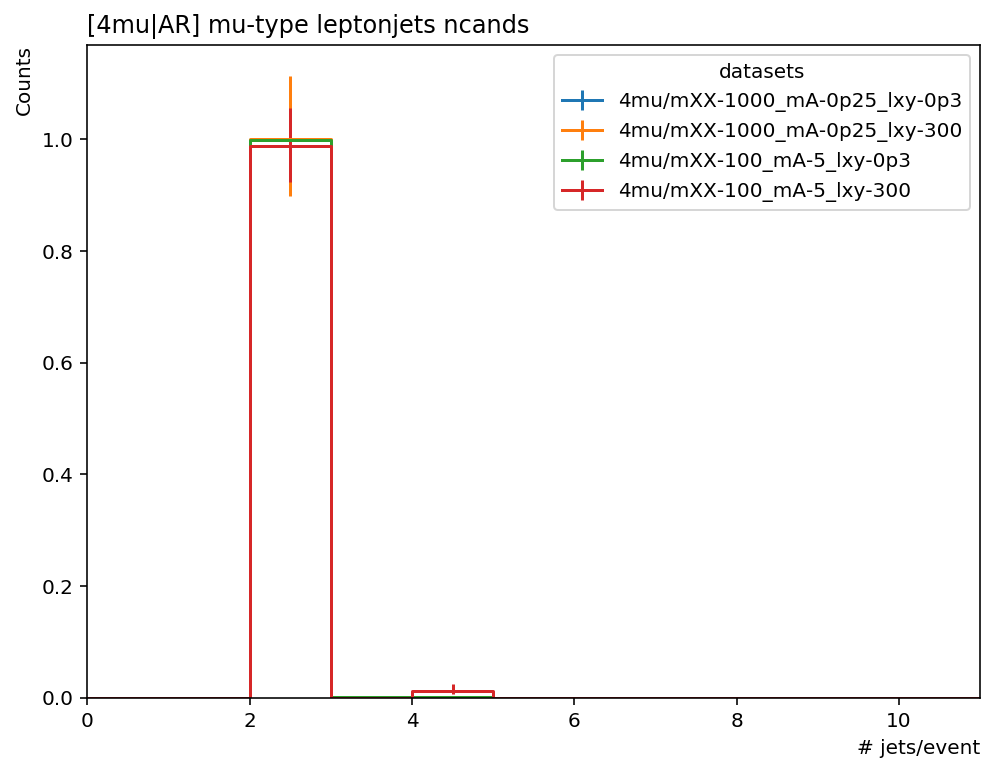

In [51]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands']['4mu/*'].integrate('channel', slice(2,3)).integrate('ljtype', 'mu'),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] mu-type leptonjets ncands', x=0.0, ha="left");